<a href="https://colab.research.google.com/github/spsgim/Scaler_Projects/blob/main/BusinessCase_AdEase_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Case**

**Company Profile**

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

**Dataset:**
<a href= "https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb"> AdEase </a>

**Data Dictionary:**
There are two csv files given

**train_1.csv:** In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

**Exog_Campaign_eng:** This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

**Concepts Tested:**
- Exploratory data analysis
- Time Series forecasting- ARIMA, SARIMAX, and Prophet

**What does “good” look like?**

- Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset
- Checking null values and understanding their reason.
- Understanding the page name format and splitting it to get different information.
- Separating different values from it like title, language, access type, and access origin.
- Visualizing the data and getting inferences from them
Converting the data to a format that can be fed to the Arima model (Pivoting etc)
- Checking if the data is stationary
  - Dickey-Fuller test
- Trying different methods for stationarity.
  - Decomposition of series.
  - Differencing the series.
- Plotting the ACF and PACF plots
  - Give insights about the characteristics of the time series.
-Modeling
  - Creating and training the Arima model
  - Getting the exogenous variable and using it to train a sarimax model
  - Use facebook prophet for forecasting
- Finding a way(grid search / etc) to find the best params for at least 1 modeling approach.
- Defining functions for all of the tasks.
- Comparing results for all languages and creating inferences and recommendations from them
- The MAPE for previous batches has been in the range of 4-8%

**Evaluation Criteria (100 points)**
- Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset (10 points)

- Exploratory Data Analysis (20 points)
  - Separating the data
  - Analyzing and visualizing the data
  - Getting inferences

- Checking stationarity (20 points)
  - Formatting the data for the model
  - Dickey fuller test
  - Decomposition
  - Differencing

- Creating model training and forecasting with ARIMA, SARIMAX (20 points)
  ACF and PACF plot.
  - Training the model.
  - Forecasting for different languages/regions.
  - Plotting the final results

- Forecasting with (20 points)
  - Facebook prophet

- Creating a pipeline for working with multiple series (10 points)

**Questionnaire:**
1. Defining the problem statements and where can this and modifications of this be used?
2. Write 3 inferences you made from the data visualizations
3. What does the decomposition of series do?
4. What level of differencing gave you a stationary series?
5. Difference between arima, sarima & sarimax.
6. Compare the number of views in different languages
7. What other methods other than grid search would be suitable to get the model for all languages?

Discussion forum link: https://www.scaler.com/academy/mentee-dashboard/discussion-forum/p/ask-me-anything-business-case-adease/21147

# **Importing Libraries**

In [1]:
# !pip install pystan~=2.14
# !pip install prophet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet

from itertools import product

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

from datetime import date
plt.rcParams['figure.figsize'] = (12,6)

import warnings
warnings.filterwarnings('ignore')

# **Importing Dataset**

In [3]:
!gdown 1T-dpAxrSM0E3xQmoBwlFOEWga9gkWkcN

Downloading...
From (original): https://drive.google.com/uc?id=1T-dpAxrSM0E3xQmoBwlFOEWga9gkWkcN
From (redirected): https://drive.google.com/uc?id=1T-dpAxrSM0E3xQmoBwlFOEWga9gkWkcN&confirm=t&uuid=18004bc0-3258-4c37-b7b1-6177f295a3b1
To: /content/train_1.csv
100% 278M/278M [00:04<00:00, 63.0MB/s]


In [4]:
AdEasy = pd.read_csv("train_1.csv")
AdEasy.head(5)

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [5]:
AdEasy.shape

(145063, 551)

In [6]:
!gdown 1cdpAe_P1ZH0yz79zHS6IcpWknKIMpEbq

Downloading...
From: https://drive.google.com/uc?id=1cdpAe_P1ZH0yz79zHS6IcpWknKIMpEbq
To: /content/Exog_Campaign_eng
100% 1.10k/1.10k [00:00<00:00, 4.11MB/s]


In [7]:
exog = pd.read_csv("Exog_Campaign_eng")
exog.head()

Exog
0     0
1     0
2     0
3     0
4     0

In [8]:
exog.shape

(550, 1)

#### Observations

1. We have data of 0.145 million pages for 550 days
2. The data isn't in the standart time series format. We will have to aggregate and transform the data into standard Time series format

# **1. Define the Problem Statement and perform pre-processing and EDA**

## **1.1. Definition of problem**

<font color='darkcyan' size=4> ***To understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views to predict and optimize the ad placement for the clients. The main aim is to forecast multiple time series for different languages for their page visit.***
</font>

## **1.2. Observations on Data**

In [9]:
# Creating a copy of the original dataset
df = AdEasy.copy()
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [10]:
df.shape

(145063, 551)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


#### **Observations**
- Restructuring, cleaning, and sanitisation the dataset is required
- Treatment of the Missing values required
- Feature extraction is required from the Page column
- Pivoting is required to structure the dataset in a standard Time series format

## **1.3. Missing Values**

In [12]:
## No. of missing values per row
(df.iloc[:,1:].isna().sum(axis=1).sort_values(ascending=False))

145062    550
90284     550
90291     550
90290     550
90289     550
         ... 
54433       0
54432       0
54431       0
54430       0
72531       0
Length: 145063, dtype: int64

We can see some rows with all the values as Null.

In [13]:
print("Distribution of the Pages with Missing Values")
na = df.iloc[:,1:].isna().sum(axis=1).value_counts().sort_index().reset_index()
na.rename(columns={"index":"missingValues", "count":"Count_of_Pages"}, inplace= True)
na['Percentage of Total'] = na["Count_of_Pages"]*100/na['Count_of_Pages'].sum()
na

Distribution of the Pages with Missing Values


missingValues  Count_of_Pages  Percentage of Total
0                0          117277            80.845564
1                1             962             0.663160
2                2             613             0.422575
3                3             326             0.224730
4                4             255             0.175786
..             ...             ...                  ...
546            546              16             0.011030
547            547              34             0.023438
548            548              44             0.030332
549            549              47             0.032400
550            550             652             0.449460

[551 rows x 3 columns]

In [14]:
print("Count of pages having Missing Values", na['Count_of_Pages'].sum() - na.loc[0, "Count_of_Pages"])
print("Percentage of pages having Missing Values", ((na['Count_of_Pages'].sum() - na.loc[0, "Count_of_Pages"])*100/na['Count_of_Pages'].sum()).round(2) ,"%")

Count of pages having Missing Values 27786
Percentage of pages having Missing Values 19.15 %


- 81.84% Pages been visited daily and has no missing values
- 27,786 pages have missing values

In [15]:
# Analysing Missing Values
na.drop(index=0, inplace= True) # Dropping first row as it is giving the count of Pages with no missing values

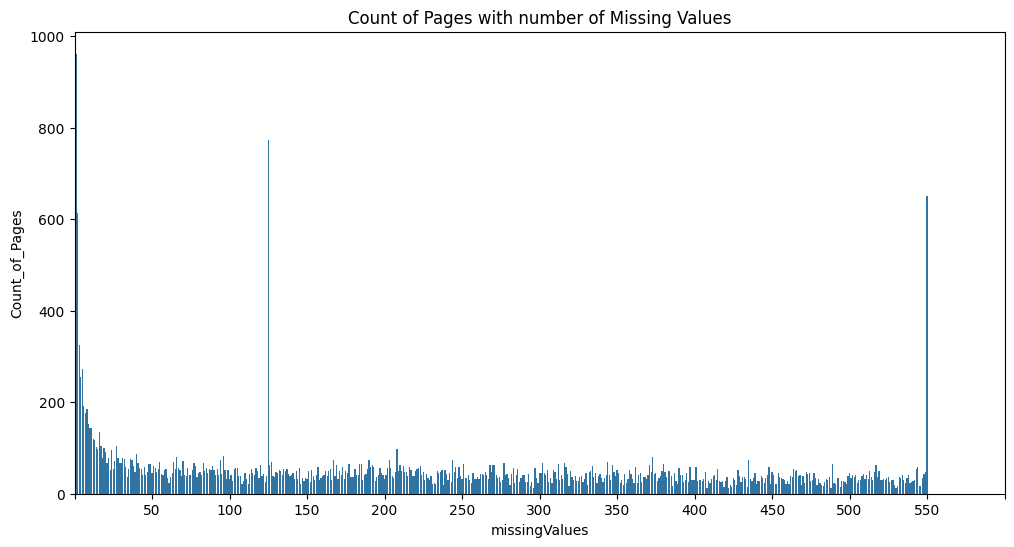

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(x=na["missingValues"], y = na["Count_of_Pages"]);
plt.title('Count of Pages with number of Missing Values');
plt.xticks(range(-1,600, 50));

In [17]:
# creating a df of rows containing missing values
null_df = df[df.isna().sum(axis=1)>0]
null_df['total_na'] = null_df.isna().sum(axis=1).values
null_df.head()

Page  2015-07-01  2015-07-02  \
4   52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   
6           91Days_zh.wikipedia.org_all-access_spider         NaN         NaN   
10           ASTRO_zh.wikipedia.org_all-access_spider         NaN         NaN   
13         AlphaGo_zh.wikipedia.org_all-access_spider         NaN         NaN   
19       B-PROJECT_zh.wikipedia.org_all-access_spider         NaN         NaN   

    2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
4          NaN         NaN         NaN         NaN         NaN         NaN   
6          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         1.0         1.0         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
19         NaN         NaN         NaN         NaN         NaN         NaN   

    2015-07-09  ...  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
4          NaN  ...         9.0        25.0        13.0         3.0   
6          NaN  ...         7.0        33.0         8.0        11.0   
10         NaN  ...        38.0        85.0        79.0        30.0   
13         NaN  ...        13.0        14.0        17.0        19.0   
19         NaN  ...        26.0        10.0         5.0         5.0   

    2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  total_na  
4         11.0        27.0        13.0        36.0        10.0       291  
6          4.0        15.0         6.0         8.0         6.0       365  
10        14.0        10.0        38.0        12.0        51.0        31  
13        56.0        21.0        13.0        21.0        11.0       212  
19        11.0        10.0         4.0         8.0         6.0       351  

[5 rows x 552 columns]

Text(0, 0.5, 'Count of Rows')

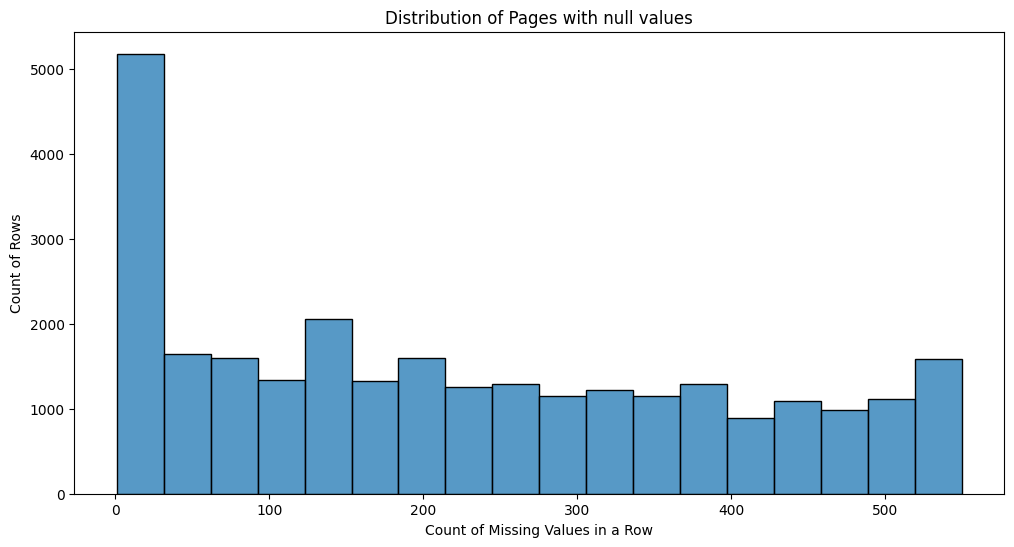

In [18]:
plt.figure(figsize=(12,6))
plt.title("Distribution of Pages with null values")
sns.histplot(data = null_df, x = 'total_na', binwidth=30)
plt.xlabel("Count of Missing Values in a Row")
plt.ylabel("Count of Rows")

Text(0, 0.5, 'Count of Missing Values')

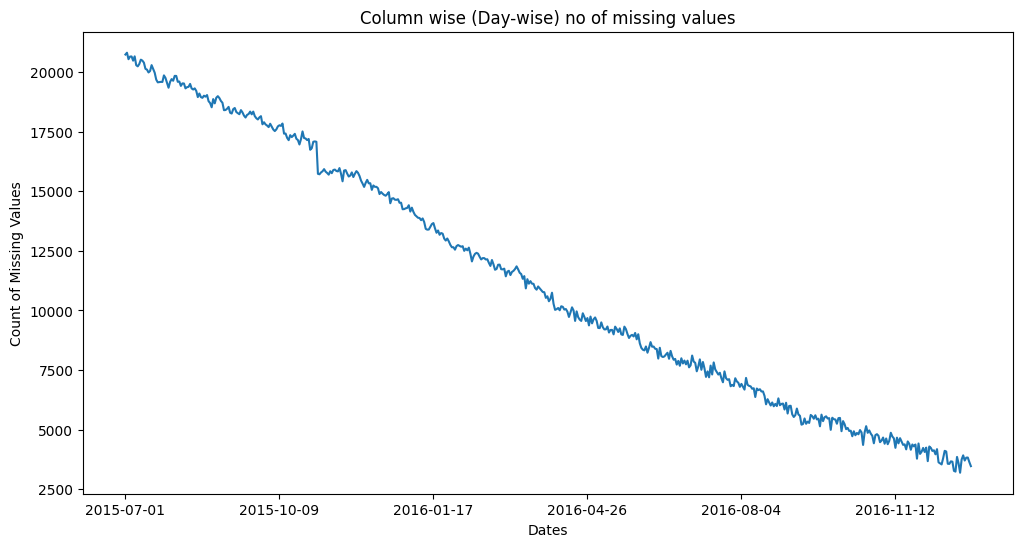

In [19]:
## Column wise missing values - which is suggesting day-wise count of missing values
plt.figure(figsize=(12,6))
plt.title("Column wise (Day-wise) no of missing values");
df.iloc[:, 1:].isna().sum().plot();
plt.xlabel("Dates")
plt.ylabel('Count of Missing Values')

#### Observations

1. The count of Null values are decreasing over time. which suggest some pages either not available/created earlier or there were no visiters

In [20]:
## Creating a copy
df_temp = df.set_index("Page").copy()

In [21]:
## dropping rows with all the values missing
df_temp.dropna(how='all', axis = 0, inplace=True)
df_temp.shape

(144411, 550)

In [22]:
# As we are going to take at least initial one year data for training, dropping rows with all the null values in the first 366 days.
df_temp.dropna(subset = df_temp.columns[:366], axis = 0, how = 'all', inplace = True)
df_temp.shape

(140014, 550)

In [23]:
# Checking how many rows left with null values present
df_temp[df_temp.isna().sum(axis=1)>0].shape

(22737, 550)

We have drop ~5000 rows with null values

In [24]:
df_temp.isna().sum(axis=1).sort_values(ascending =False).value_counts().sort_index()

0      117277
1         962
2         613
3         326
4         255
        ...  
544         7
545         1
547         8
548         4
549         9
Name: count, Length: 547, dtype: int64

Analysing page with 549 missing values

In [25]:
pg = df_temp.loc['Special:WhatLinksHere/File:DSO-Ensemble.jpg_www.mediawiki.org_all-access_spider', :].reset_index()

In [26]:
pg[pg['Special:WhatLinksHere/File:DSO-Ensemble.jpg_www.mediawiki.org_all-access_spider'].notna()]

index  \
321  2016-05-17   

     Special:WhatLinksHere/File:DSO-Ensemble.jpg_www.mediawiki.org_all-access_spider  
321                                                0.0

- So we have some pages with O visits

In [27]:
# ## We do have enough null values, let's drop rows with more than 180 null values
# # we can drop those pages which are created recently (in last 6 months).
# # So, dropping rows with more than 300 missing values in the initial on year.

df_temp.dropna(subset = df_temp.columns[:366], thresh = 180, inplace = True)
df_temp.shape

(131395, 550)

In [28]:
# Checking how many rows left with null values present
df_temp[df_temp.isna().sum(axis=1)>0].shape

(14118, 550)

#### **Imputation**

In [29]:
df_imputed = df_temp.interpolate(method='linear', axis=1)

In [30]:
# Checking how many rows left with null values present
df_imputed[df_imputed.isna().sum(axis=1)>0].shape

(7387, 550)

Filling remaining missing values with median assumming the fact that if the page was created earlier, the visits on that page would be closer to the median visits of the page

In [31]:
## Filling remaining rows with median
df_filled = df_imputed.apply(lambda row: row.fillna(row.median()), axis=1)
df_filled.head()

2015-07-01  2015-07-02  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider           18.0        11.0   
2PM_zh.wikipedia.org_all-access_spider            11.0        14.0   
3C_zh.wikipedia.org_all-access_spider              1.0         0.0   
4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
5566_zh.wikipedia.org_all-access_spider           12.0         7.0   

                                            2015-07-03  2015-07-04  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider            5.0        13.0   
2PM_zh.wikipedia.org_all-access_spider            15.0        18.0   
3C_zh.wikipedia.org_all-access_spider              1.0         1.0   
4minute_zh.wikipedia.org_all-access_spider        10.0        94.0   
5566_zh.wikipedia.org_all-access_spider            4.0         5.0   

                                            2015-07-05  2015-07-06  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider           14.0         9.0   
2PM_zh.wikipedia.org_all-access_spider            11.0        13.0   
3C_zh.wikipedia.org_all-access_spider              0.0         4.0   
4minute_zh.wikipedia.org_all-access_spider         4.0        26.0   
5566_zh.wikipedia.org_all-access_spider           20.0         8.0   

                                            2015-07-07  2015-07-08  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider            9.0        22.0   
2PM_zh.wikipedia.org_all-access_spider            22.0        11.0   
3C_zh.wikipedia.org_all-access_spider              0.0         3.0   
4minute_zh.wikipedia.org_all-access_spider        14.0         9.0   
5566_zh.wikipedia.org_all-access_spider            5.0        17.0   

                                            2015-07-09  2015-07-10  ...  \
Page                                                                ...   
2NE1_zh.wikipedia.org_all-access_spider           26.0        24.0  ...   
2PM_zh.wikipedia.org_all-access_spider            10.0         4.0  ...   
3C_zh.wikipedia.org_all-access_spider              4.0         4.0  ...   
4minute_zh.wikipedia.org_all-access_spider        11.0        16.0  ...   
5566_zh.wikipedia.org_all-access_spider           24.0         7.0  ...   

                                            2016-12-22  2016-12-23  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider           32.0        63.0   
2PM_zh.wikipedia.org_all-access_spider            17.0        42.0   
3C_zh.wikipedia.org_all-access_spider              3.0         1.0   
4minute_zh.wikipedia.org_all-access_spider        32.0        10.0   
5566_zh.wikipedia.org_all-access_spider           16.0        27.0   

                                            2016-12-24  2016-12-25  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider           15.0        26.0   
2PM_zh.wikipedia.org_all-access_spider            28.0        15.0   
3C_zh.wikipedia.org_all-access_spider              1.0         7.0   
4minute_zh.wikipedia.org_all-access_spider        26.0        27.0   
5566_zh.wikipedia.org_all-access_spider            8.0        17.0   

                                            2016-12-26  2016-12-27  \
Page                                                                 
2NE1_zh.wikipedia.org_all-access_spider           14.0        20.0   
2PM_zh.wikipedia.org_all-access_spider             9.0        30.0   
3C_zh.wikipedia.org_all-access_spider              4.0         4.0   
4minute_zh.wikipedia.org_all-access_spider        16.0        11.0   
5566_zh.wikipedia.org_all-access_spider           32.0        19.0   

                                            2016-12-28  2016-12-29  \
Page       

In [32]:
df = df_filled.reset_index().copy()

In [33]:
df.isna().sum().sum()

0

In [34]:
df.drop_duplicates(inplace=True)
df.shape

(131395, 551)

## **1.4. Modification in the data**

In [35]:
## Splitting Page column to extract Language and other features
df[['pageName', "Language", "accessType", "accessOrigin"]] = df.Page.str.rsplit("_",n=3, expand=True)
df['Language'] = df["Language"].str.replace(".wikipedia.org", "")
df.head()

Page  2015-07-01  2015-07-02  \
0     2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1      2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2       3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3  4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4     5566_zh.wikipedia.org_all-access_spider        12.0         7.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         4.0         5.0        20.0         8.0         5.0        17.0   

   2015-07-09  ...  2016-12-26  2016-12-27  2016-12-28  2016-12-29  \
0        26.0  ...        14.0        20.0        22.0        19.0   
1        10.0  ...         9.0        30.0        52.0        45.0   
2         4.0  ...         4.0         4.0         6.0         3.0   
3        11.0  ...        16.0        11.0        17.0        19.0   
4        24.0  ...        32.0        19.0        23.0        17.0   

   2016-12-30  2016-12-31  pageName  Language  accessType  accessOrigin  
0        18.0        20.0      2NE1        zh  all-access        spider  
1        26.0        20.0       2PM        zh  all-access        spider  
2         4.0        17.0        3C        zh  all-access        spider  
3        10.0        11.0   4minute        zh  all-access        spider  
4        17.0        50.0      5566        zh  all-access        spider  

[5 rows x 555 columns]

In [36]:
df.groupby(["Language"])["Page"].count().sort_values(ascending = False)

Language
en                       22053
ja                       19098
de                       17070
fr                       16700
zh                       14703
ru                       14121
es                       13363
commons.wikimedia.org     8110
www.mediawiki.org         6177
Name: Page, dtype: int64

In [37]:
## There are media pages as well. Renaming media pages
df["Language"]=df["Language"].str.replace("commons.wikimedia.org", "media").replace("www.mediawiki.org","media")

```{"en":"English",
 "ja":"Japanese",
 "de":"German",
 "fr":"French",
 "zh":"Chinese",
 "ru":"Russian",
 "es":"Spanish",
 }```

## **1.5. EDA**

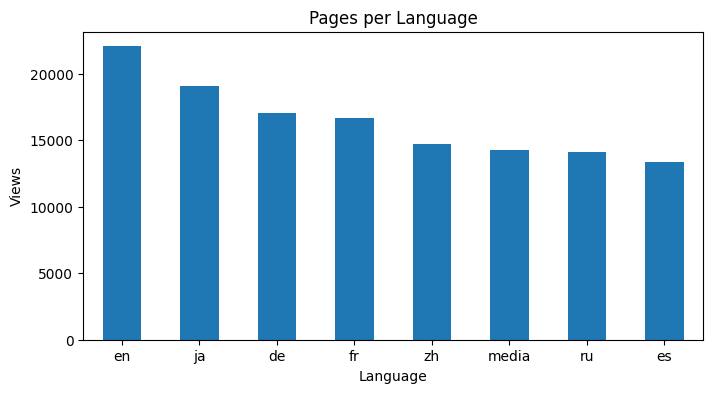

In [38]:
plt.figure(figsize = (8, 4))
df.groupby(["Language"])["Page"].count().sort_values(ascending = False).plot(kind="bar")
plt.title(f"Pages per Language")
plt.ylabel("Views")
plt.xticks(rotation = 0)
plt.show()

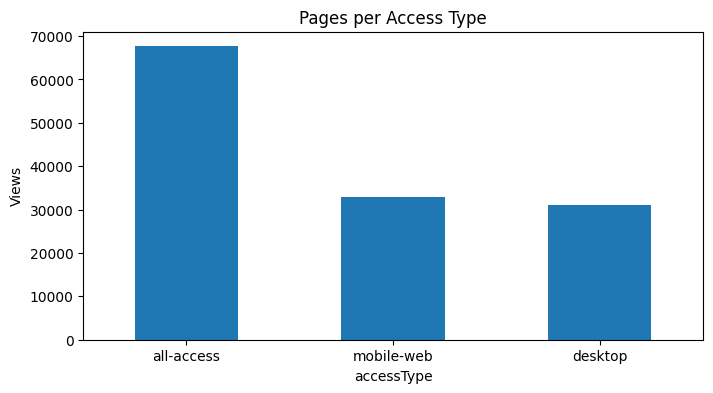

In [39]:
plt.figure(figsize = (8, 4))
df.groupby(["accessType"])["Page"].count().sort_values(ascending = False).plot(kind='bar')
plt.title(f"Pages per Access Type")
plt.ylabel("Views")
plt.xticks(rotation = 0)
plt.show()

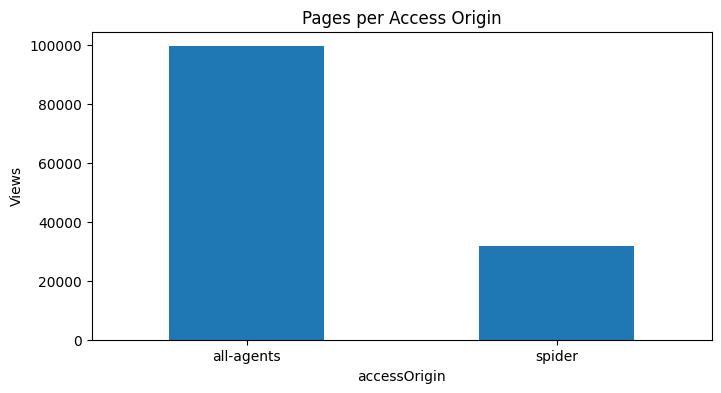

In [40]:
plt.figure(figsize = (8, 4))
df.groupby(["accessOrigin"])["Page"].count().sort_values(ascending = False).plot(kind='bar')
plt.title(f"Pages per Access Origin")
plt.ylabel("Views")
plt.xticks(rotation = 0)
plt.show()

In [41]:
df1=df.copy()

In [42]:
df1.drop(columns=['Page', 'pageName', 'accessType', 'accessOrigin'], inplace=True)

## **1.6. Aggregation and Pivoting**

In [43]:
df2 = df1.groupby(['Language']).agg('sum').transpose()
df2.head()

Language              de            en            es            fr  \
2015-07-01  1.341113e+07  8.569934e+07  1.539684e+07  8.914539e+06   
2015-07-02  1.323059e+07  8.540327e+07  1.471923e+07  8.967446e+06   
2015-07-03  1.270418e+07  8.111685e+07  1.354516e+07  8.640255e+06   
2015-07-04  1.167046e+07  8.441139e+07  1.271948e+07  9.201938e+06   
2015-07-05  1.354190e+07  8.713869e+07  1.382312e+07  9.041951e+06   

Language              ja         media            ru            zh  
2015-07-01  1.207302e+07  1.600880e+06  9.638389e+06  4.396596e+06  
2015-07-02  1.382873e+07  1.671982e+06  9.801788e+06  4.401151e+06  
2015-07-03  1.251151e+07  1.585412e+06  9.097034e+06  4.368667e+06  
2015-07-04  1.566172e+07  1.369287e+06  8.566818e+06  4.407916e+06  
2015-07-05  1.503256e+07  1.505742e+06  9.108820e+06  4.683689e+06

In [44]:
df2.index = pd.to_datetime(df2.index)

In [45]:
df2 = df2.rename_axis("Date", axis=1)

In [46]:
lang_dict = {"en":"English", "ja":"Japanese", "de":"German", "fr":"French", "zh":"Chinese", "ru":"Russian", "es":"Spanish", 'media':'media'}
df2.rename(columns=lang_dict, inplace = True)

In [47]:
## Cheaking for missing dates
total_days = (df2.index[-1]-df2.index[0]).days + 1
print(f'Difference is {total_days} days')

Difference is 550 days


Thus, no missing dates

In [48]:
df2.dtypes

Date
German      float64
English     float64
Spanish     float64
French      float64
Japanese    float64
media       float64
Russian     float64
Chinese     float64
dtype: object

In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   German    550 non-null    float64
 1   English   550 non-null    float64
 2   Spanish   550 non-null    float64
 3   French    550 non-null    float64
 4   Japanese  550 non-null    float64
 5   media     550 non-null    float64
 6   Russian   550 non-null    float64
 7   Chinese   550 non-null    float64
dtypes: float64(8)
memory usage: 38.7 KB


In [50]:
print('Values are in Millions')
(df2/1000000).describe().round(2)

Values are in Millions


Date   German  English  Spanish  French  Japanese   media  Russian  Chinese
count  550.00   550.00   550.00  550.00    550.00  550.00   550.00   550.00
mean    15.89   105.24    17.04   11.45     15.30    2.05    14.39     5.36
std      1.94    22.20     3.27    1.71      2.31    0.42     5.69     0.72
min     11.56    77.35     8.96    7.32      9.02    1.28     7.55     3.25
25%     14.57    91.51    14.50   10.57     13.70    1.79    12.09     4.91
50%     15.57   100.12    16.98   11.35     15.20    1.96    13.43     5.37
75%     17.06   111.31    20.02   12.26     16.69    2.22    14.63     5.75
max     23.42   198.89    29.46   19.61     29.36    4.72    44.26    10.84

## **1.7. Time Series Plots**

In [51]:
# Converting counts in Millions
df3 = (df2/1000000).copy()

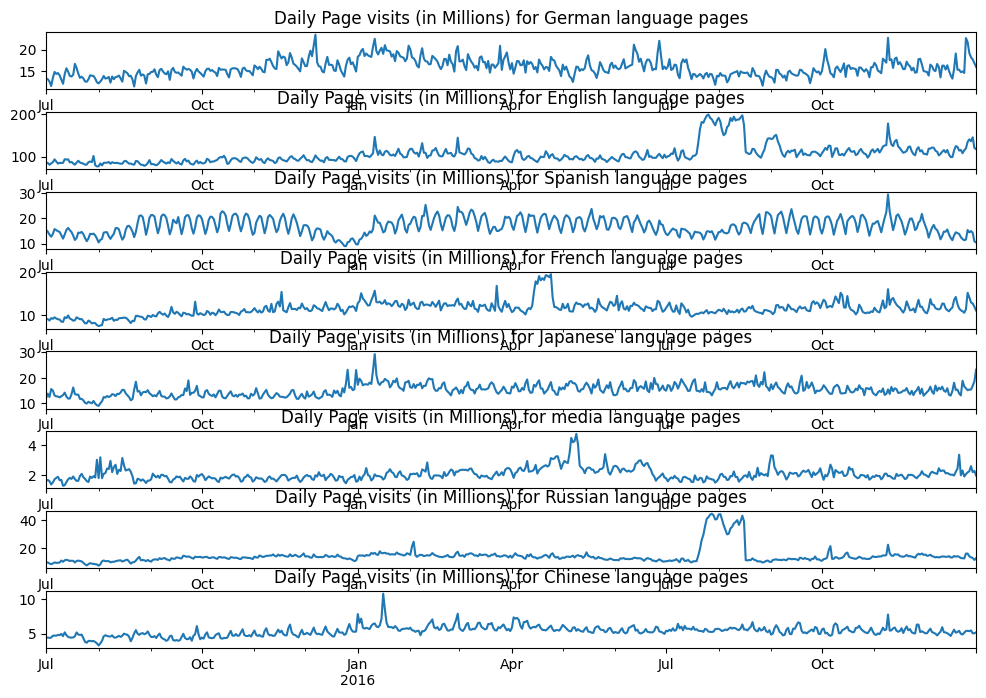

In [52]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace = 0.4)
ind = 1
for lang in df3.columns:
  plt.subplot(8, 1, ind)
  df3[lang].plot();
  plt.title(f'Daily Page visits (in Millions) for {lang} language pages')
  ind+=1
  # plt.legend()

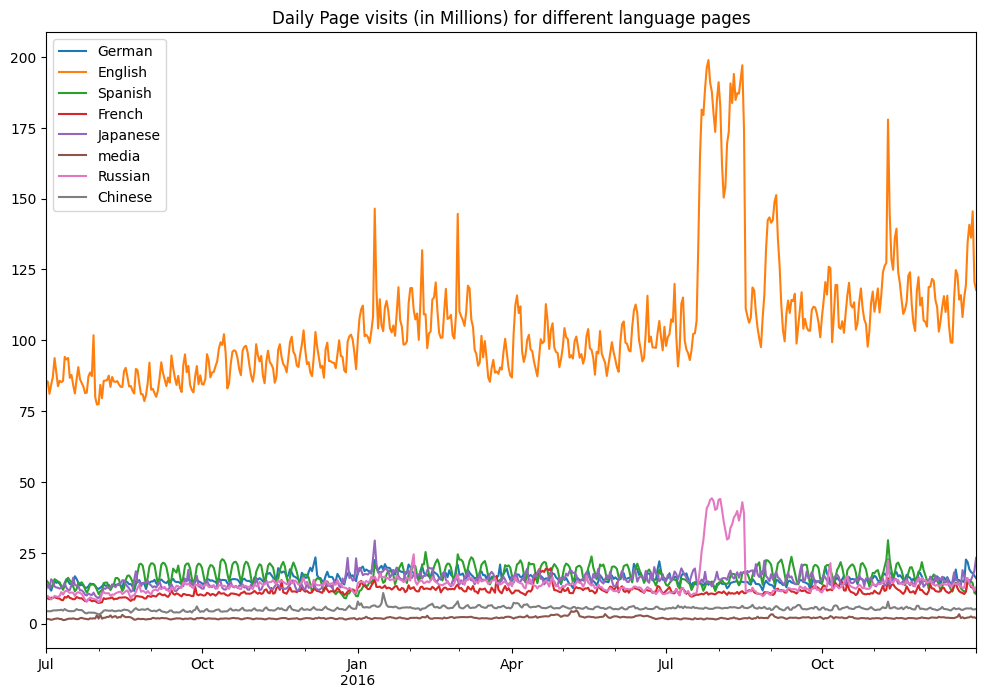

In [53]:
plt.figure(figsize=(12,8))
# plt.subplots_adjust(hspace = 0.4)
# ind = 1
for lang in df3.columns:
  # plt.subplot(8, 1, ind)
  df3[lang].plot();
  plt.title(f'Daily Page visits (in Millions) for different language pages')
  # ind+=1
  plt.legend()

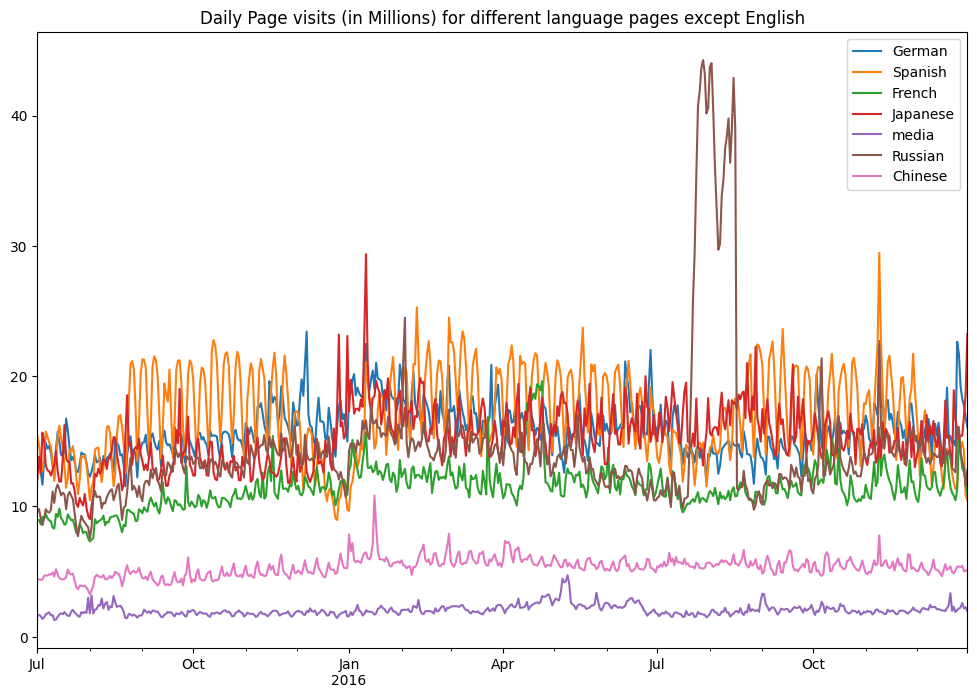

In [54]:
plt.figure(figsize=(12,8))
# plt.subplots_adjust(hspace = 0.4)
# ind = 1
for lang in df3.columns.drop("English"):
  # plt.subplot(8, 1, ind)
  df3[lang].plot();
  plt.title(f'Daily Page visits (in Millions) for different language pages except English')
  # ind+=1
  plt.legend()

#### Observations

Looking at the above plot we can say that language - English is preferred over others. People view pages in English language way more than the rest.

Also there is a very interesting insight that there are some peaks in the data, especially if we look at 2016-08-04 in both english and russian language. To study about this in detail, we will look at the Exogenous data provided to us for English language.

# **2. Stationarity, decomposition, detrending, ACF, and PACF**

## **2.1. Stationarity test and decomposition**

In [55]:
# Creating a function to test the stationarity
def adf_test(dataset):
   pvalue = adfuller(dataset)[1]
   if pvalue < 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

In [56]:
## Test for stationarity
for lang in df3.columns:
  print(lang, end=" : ")
  adf_test(df3[lang])

German : Sequence is not stationary
English : Sequence is not stationary
Spanish : Sequence is stationary
French : Sequence is stationary
Japanese : Sequence is not stationary
media : Sequence is stationary
Russian : Sequence is stationary
Chinese : Sequence is not stationary


#### Observations

The given time series data for German, English, Japanese, and Chinese language is not stationary but stationary for other languages

## **2.2. De-trending and de-seasoning**

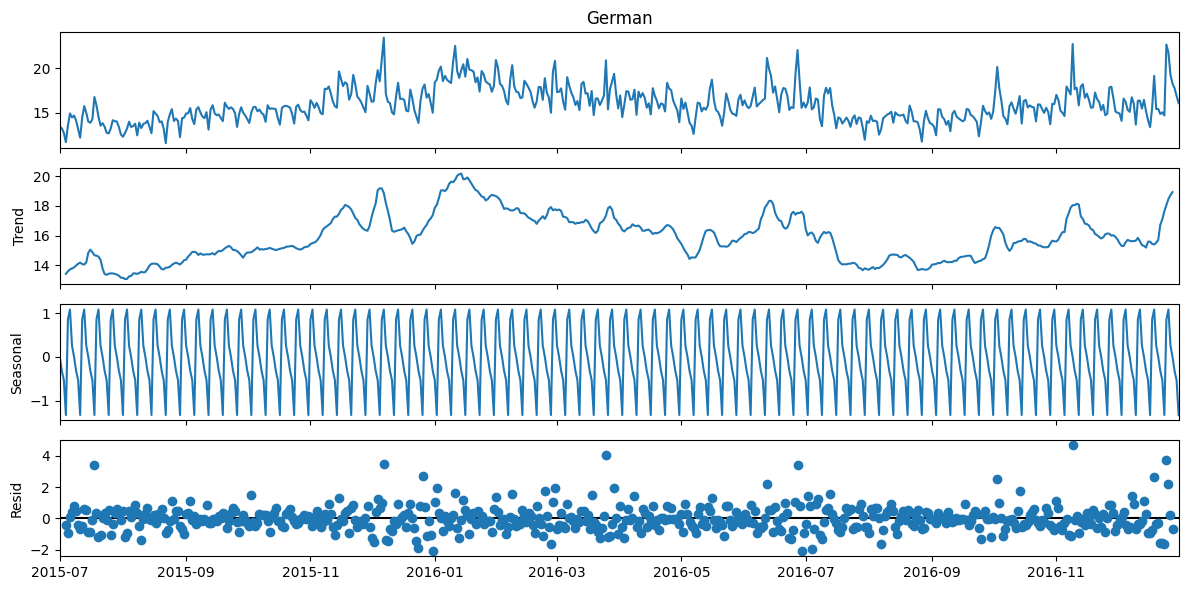

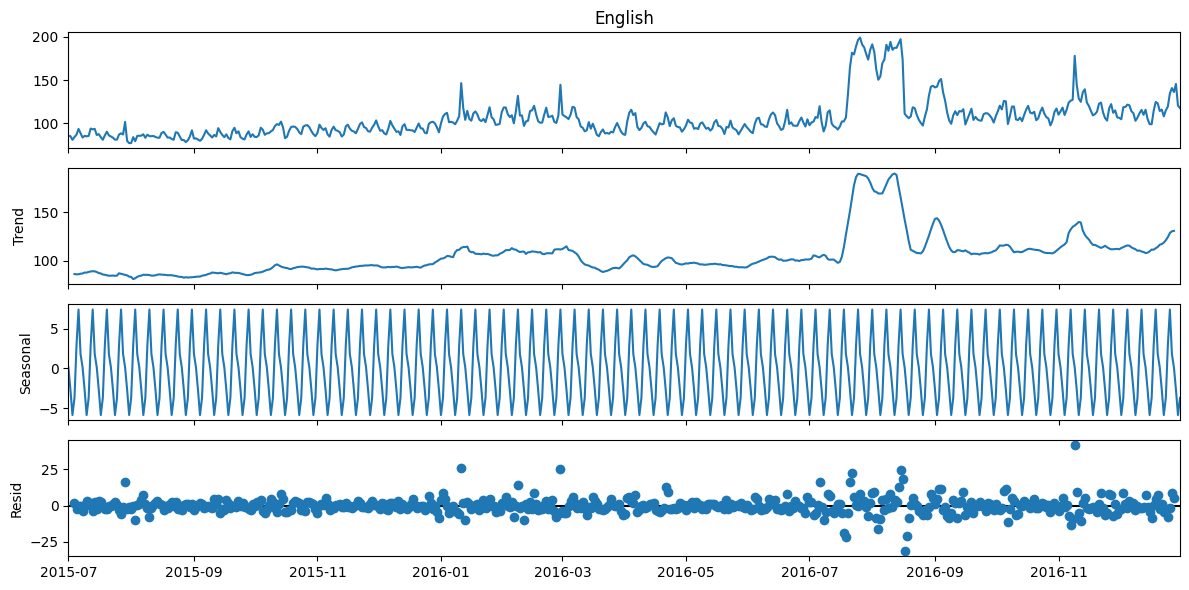

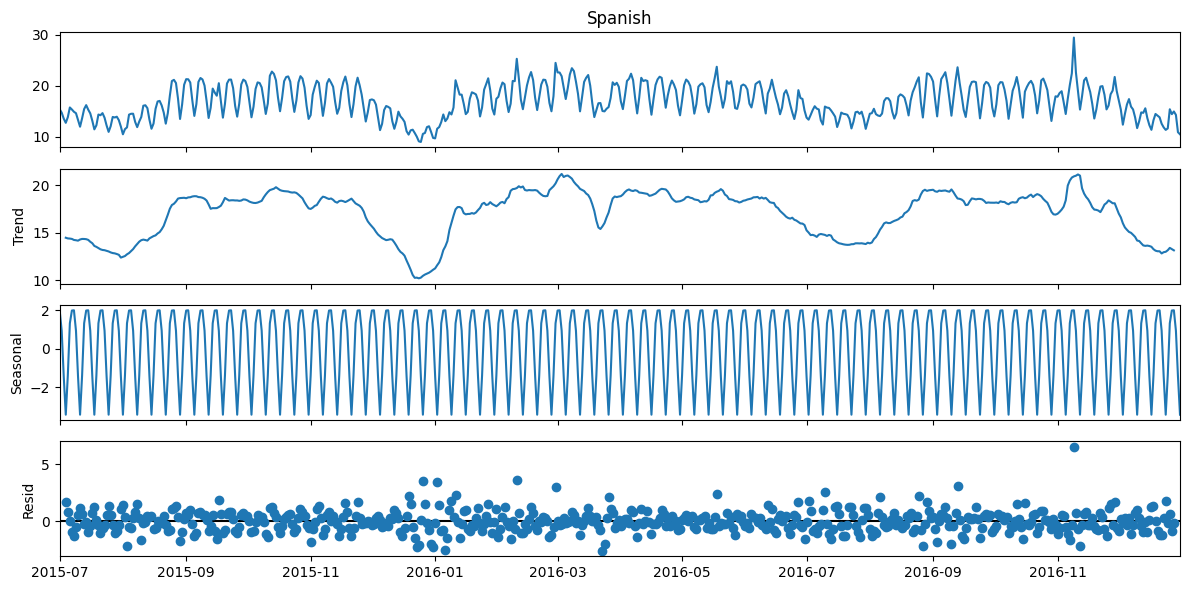

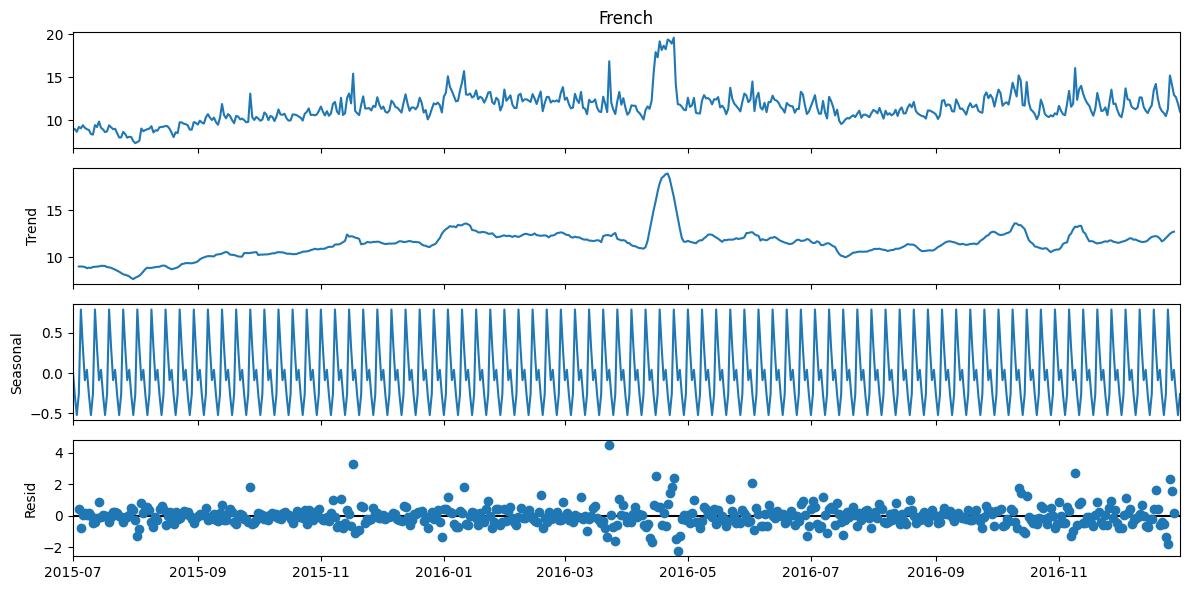

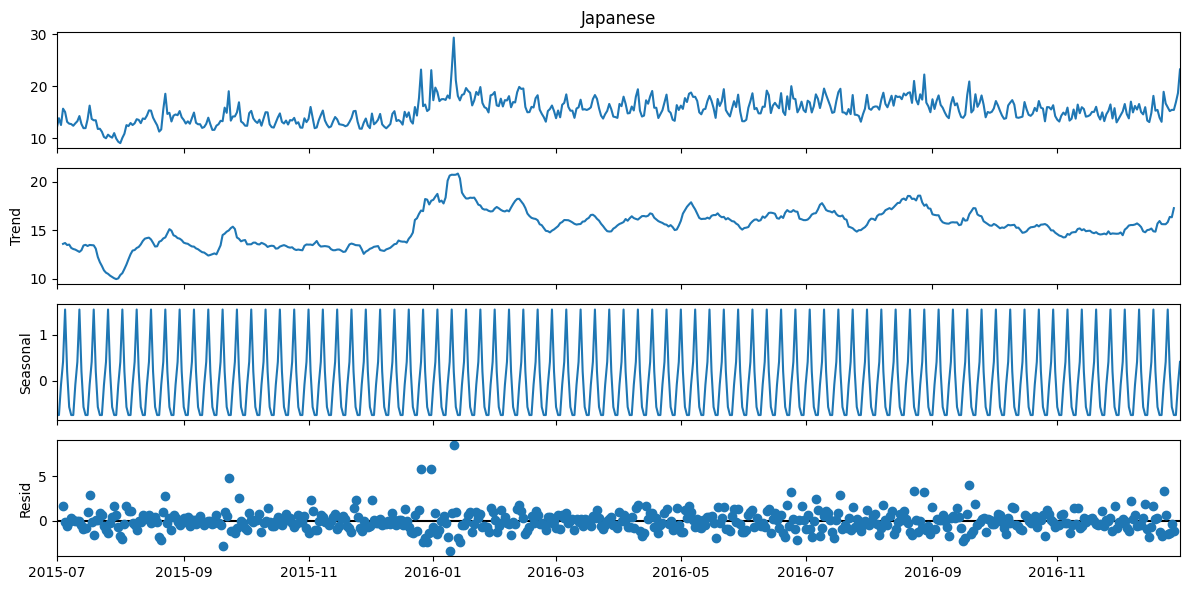

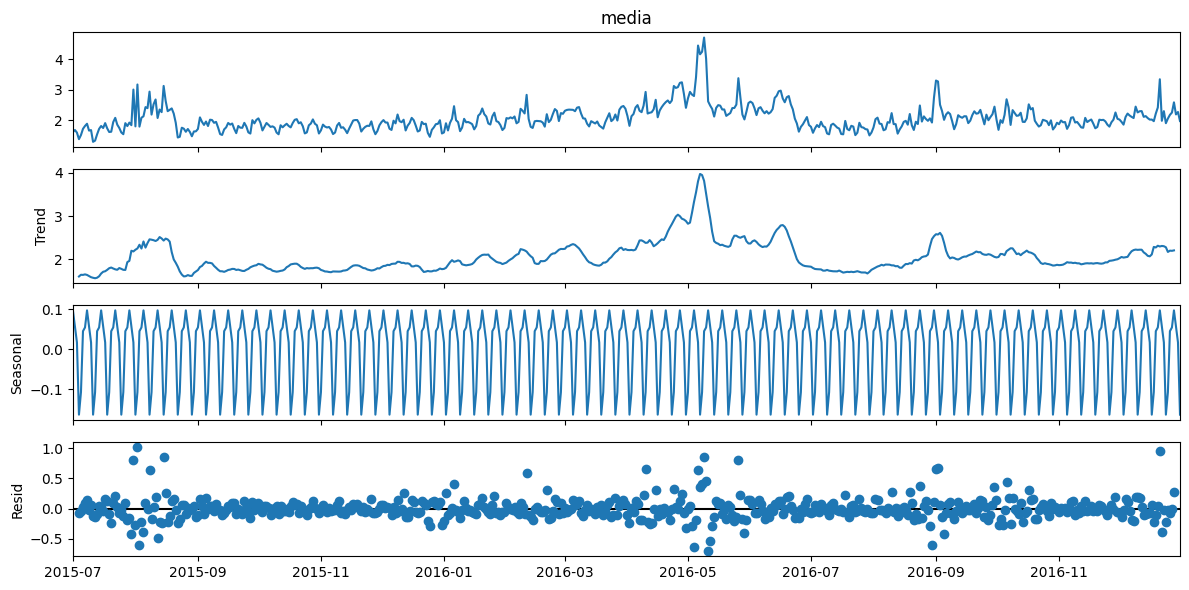

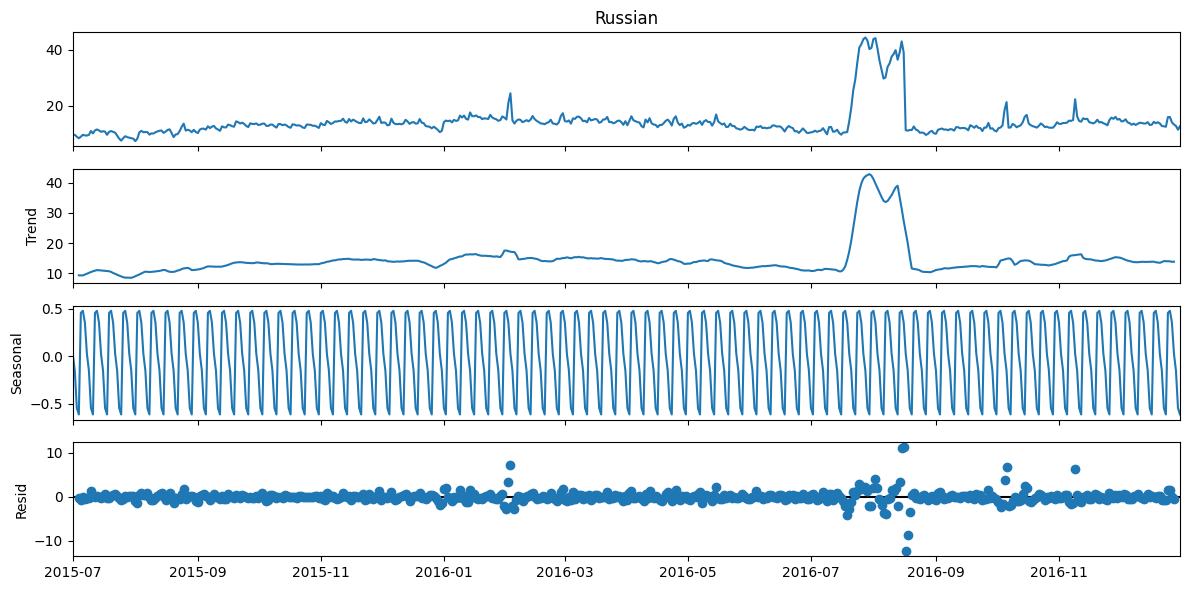

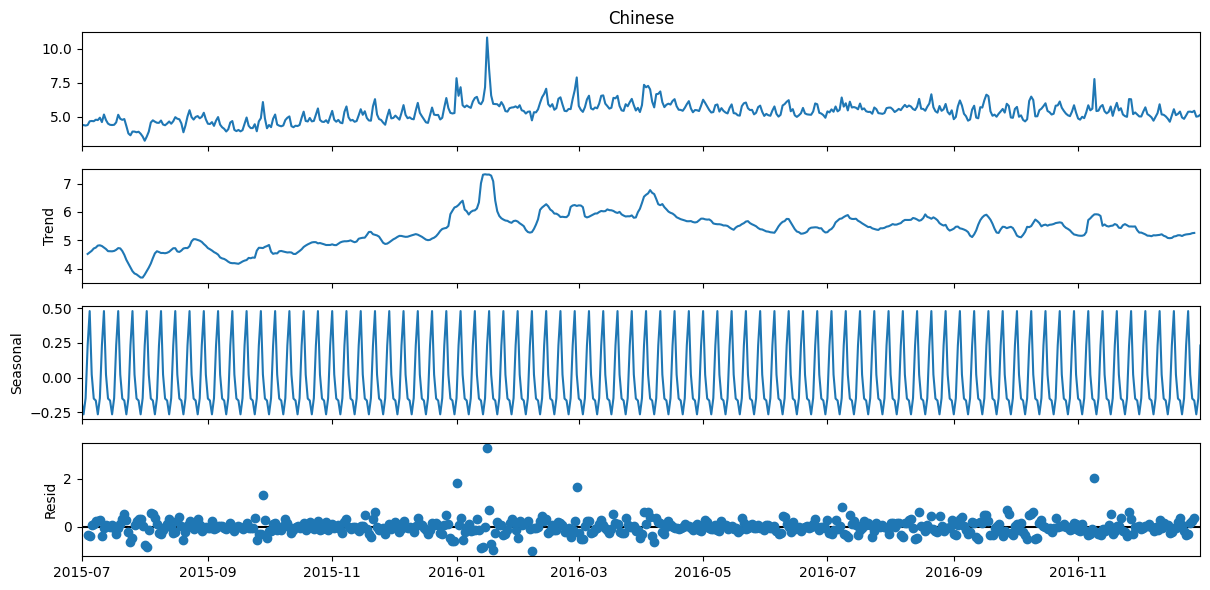

In [57]:
## Decomposition
for lang in df3.columns:
  model = sm.tsa.seasonal_decompose(df3[lang], model='additive')
  model.plot();

### **Detrend**

In [58]:
detrend = {}
for lang in ['German', 'English', 'Japanese', 'Chinese']:
  detrend[lang] = df3[lang].diff().dropna()

detrend = pd.DataFrame(detrend)
detrend.head()

German   English  Japanese   Chinese
2015-07-02 -0.180537 -0.296069  1.755712  0.004555
2015-07-03 -0.526418 -4.286416 -1.317220 -0.032484
2015-07-04 -1.033714  3.294534  3.150203  0.039249
2015-07-05  1.871435  2.727303 -0.629156  0.275773
2015-07-06  1.348719  6.601860 -1.906592  0.021581

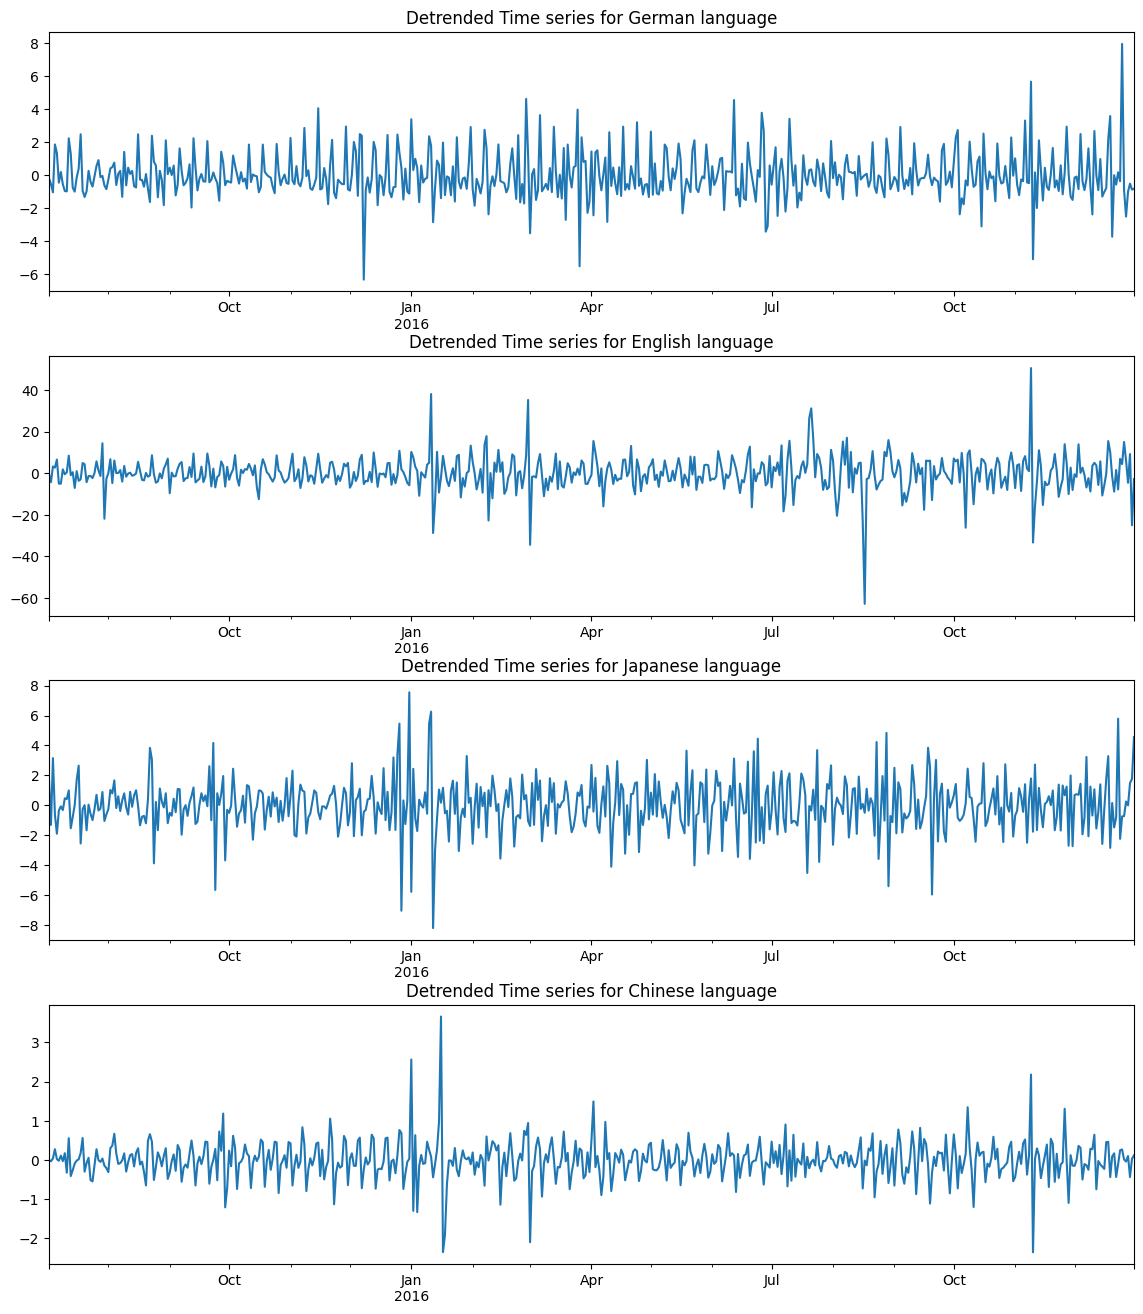

In [59]:
plt.figure(figsize=(14, 16))

plt.subplots_adjust(hspace=0.25)

ind = 1
for lang in ['German', 'English', 'Japanese', 'Chinese']:
  plt.subplot(4,1,ind)
  detrend[lang].plot();
  ind +=1
  plt.title(f"Detrended Time series for {lang} language")

## **2.3. Getting insights into time series characteristics**

ACF and PACF Plots

In [60]:
## Merging into DF of Detrended Languages TS and Stationary Languages TS

df_temp = df3.drop(columns=detrend.columns).copy()
detrend  = pd.merge(detrend, df_temp, left_index=True, right_index=True)
detrend

German    English  Japanese   Chinese    Spanish     French  \
2015-07-02 -0.180537  -0.296069  1.755712  0.004555  14.719230   8.967446   
2015-07-03 -0.526418  -4.286416 -1.317220 -0.032484  13.545160   8.640255   
2015-07-04 -1.033714   3.294534  3.150203  0.039249  12.719476   9.201938   
2015-07-05  1.871435   2.727303 -0.629156  0.275773  13.823122   9.041951   
2015-07-06  1.348719   6.601860 -1.906592  0.021581  15.738343   9.401025   
...              ...        ...       ...       ...        ...        ...   
2016-12-27 -2.504856   6.129165  0.246293 -0.038899  14.425968  14.139285   
2016-12-28 -0.988807  -4.544192 -0.010860  0.101434  14.948856  12.936041   
2016-12-29 -0.507080   9.283065  1.482381 -0.433767  14.278004  12.661840   
2016-12-30 -0.867905 -24.995288  1.761412  0.030859  10.878570  11.903014   
2016-12-31 -0.805770  -2.735923  4.560909  0.117505  10.472470  10.996506   

               media    Russian  
2015-07-02  1.671982   9.801788  
2015-07-03  1.585412   9.097034  
2015-07-04  1.369287   8.566818  
2015-07-05  1.505742   9.108820  
2015-07-06  1.710564   9.794485  
...              ...        ...  
2016-12-27  2.246792  14.195474  
2016-12-28  2.585324  13.438950  
2016-12-29  2.186300  12.932871  
2016-12-30  2.266006  11.582426  
2016-12-31  1.967183  12.833005  

[549 rows x 8 columns]

ACF and PACF for German Language


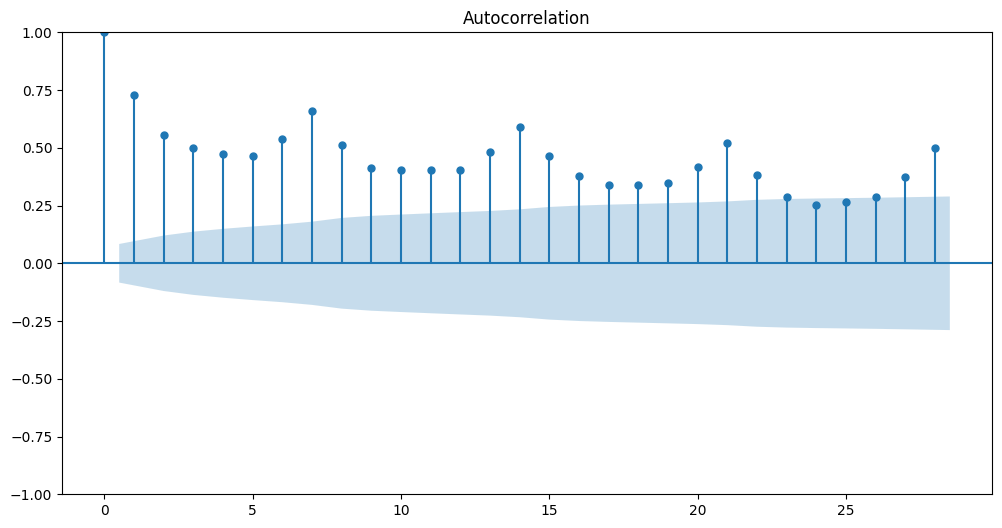

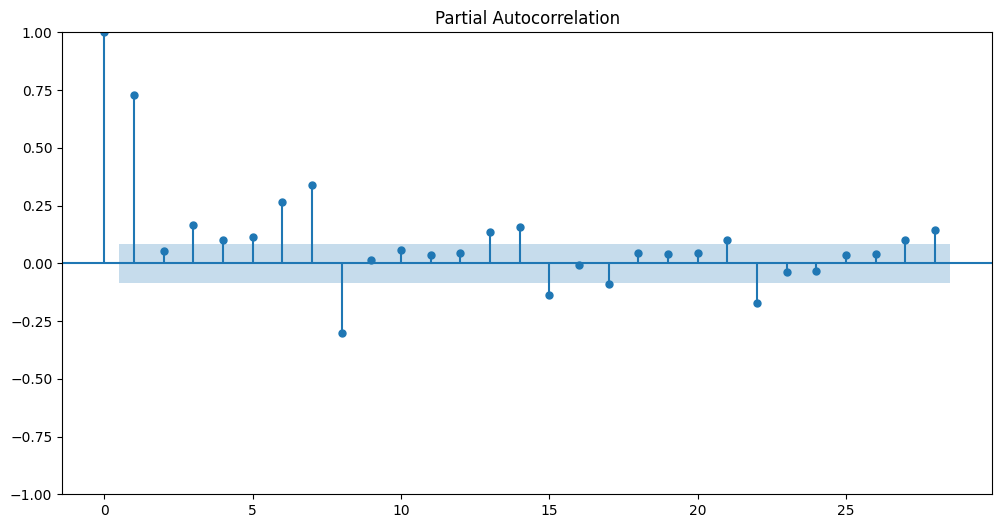

ACF and PACF for English Language


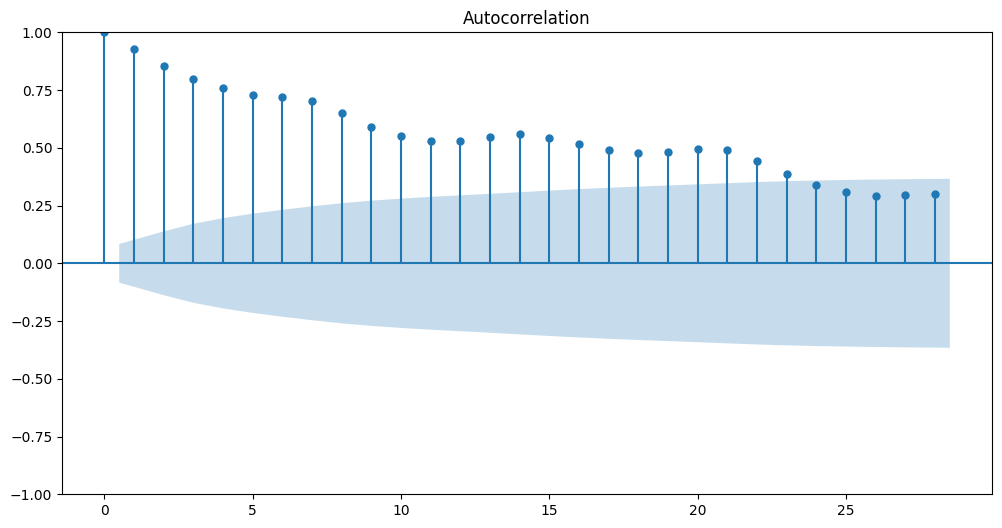

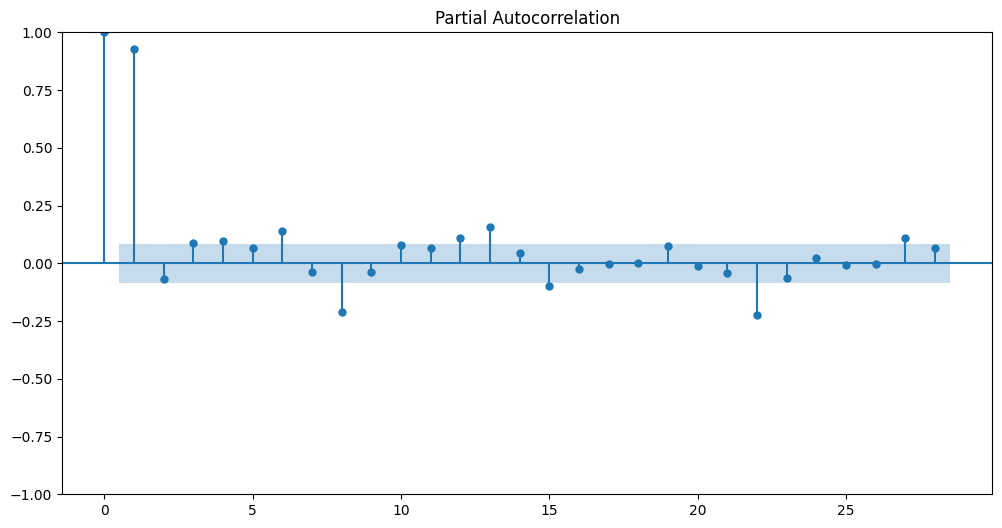

ACF and PACF for Japanese Language


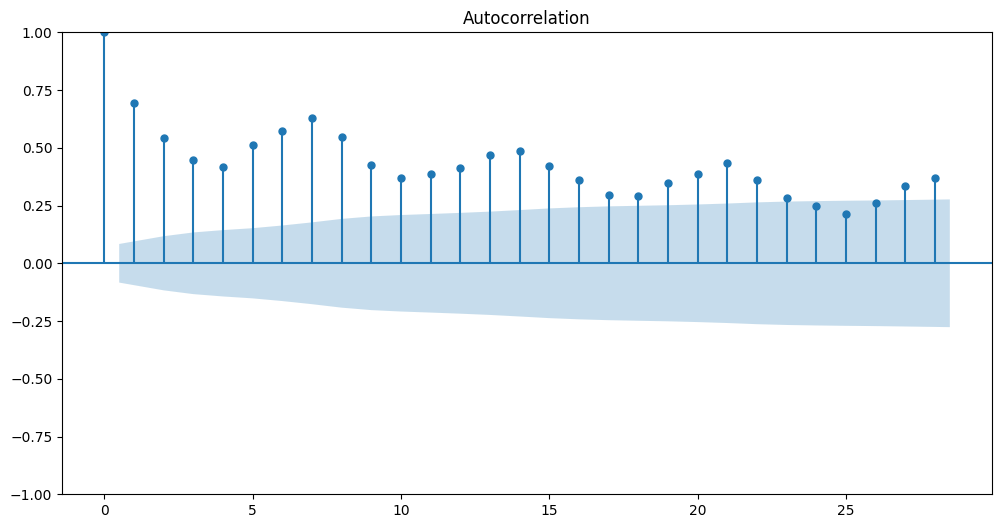

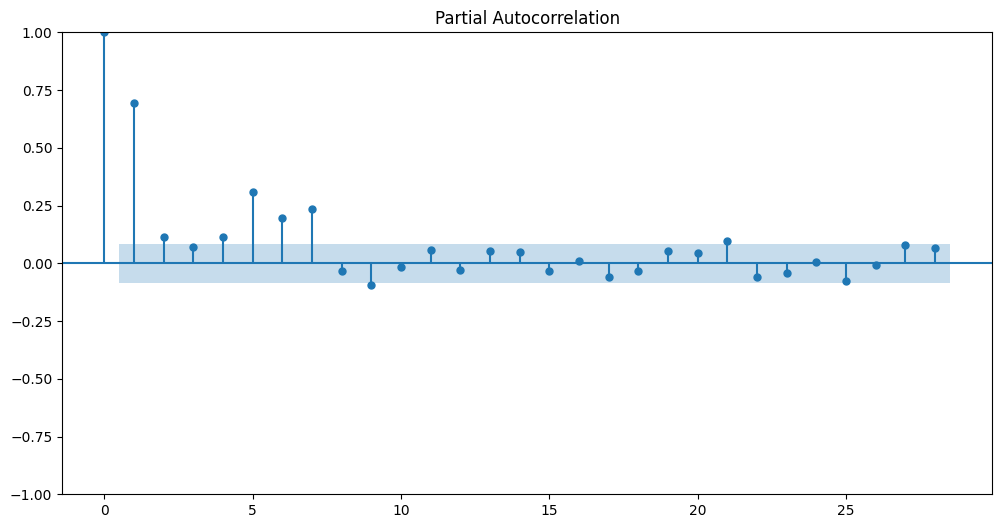

ACF and PACF for Chinese Language


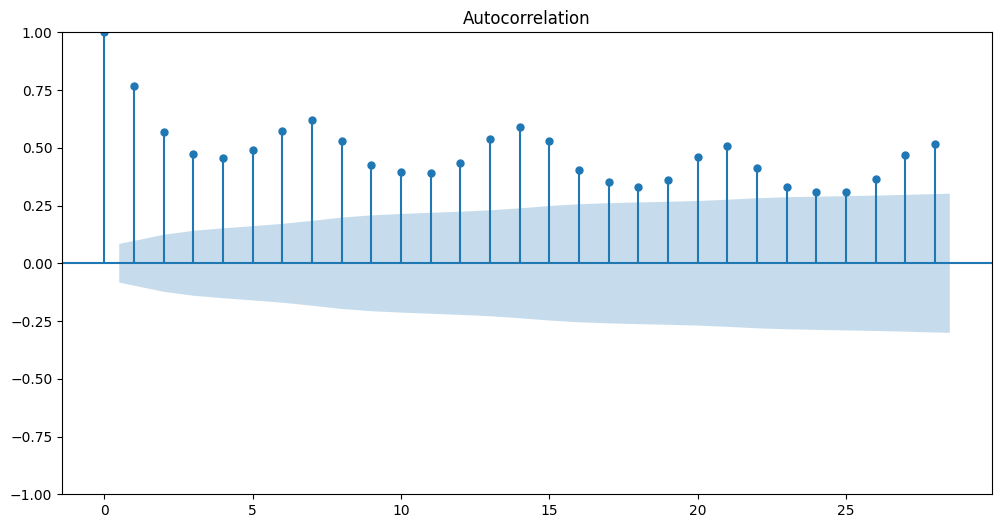

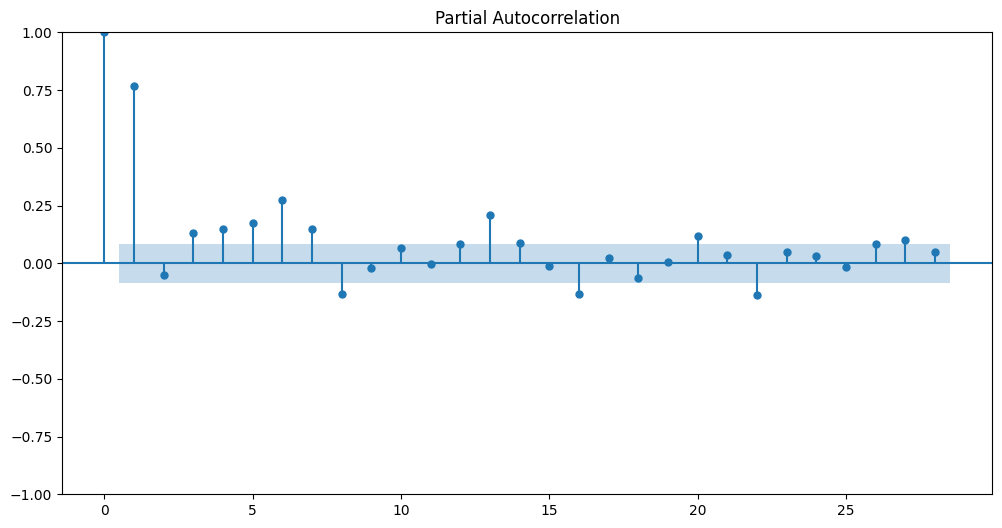

ACF and PACF for Spanish Language


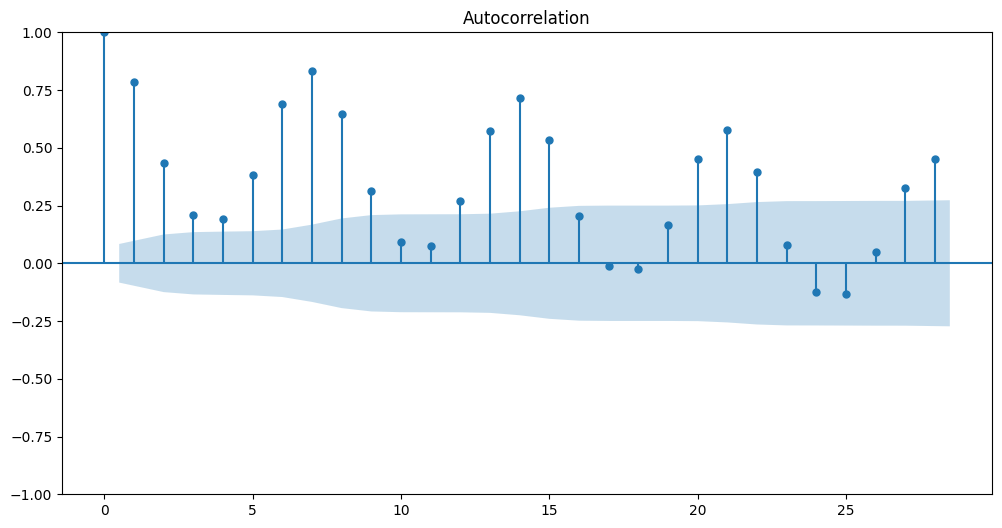

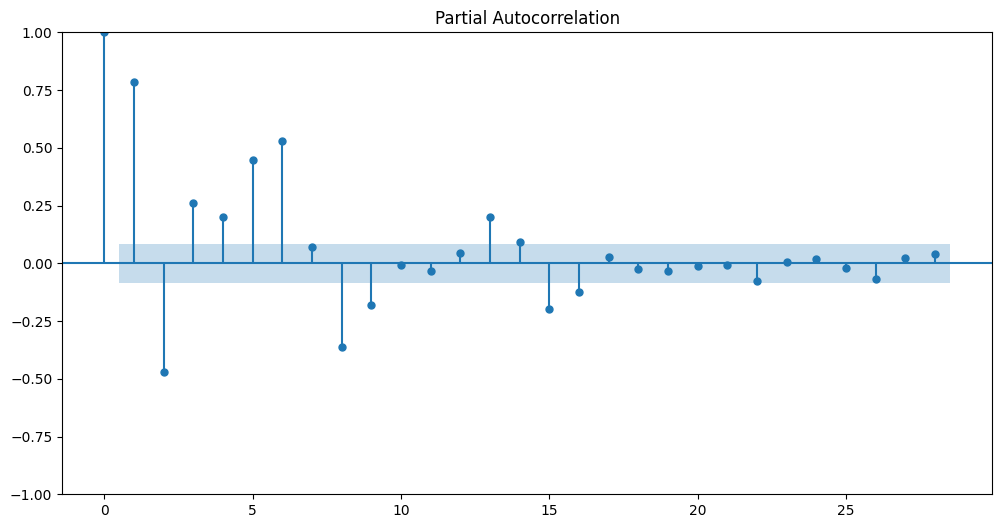

ACF and PACF for French Language


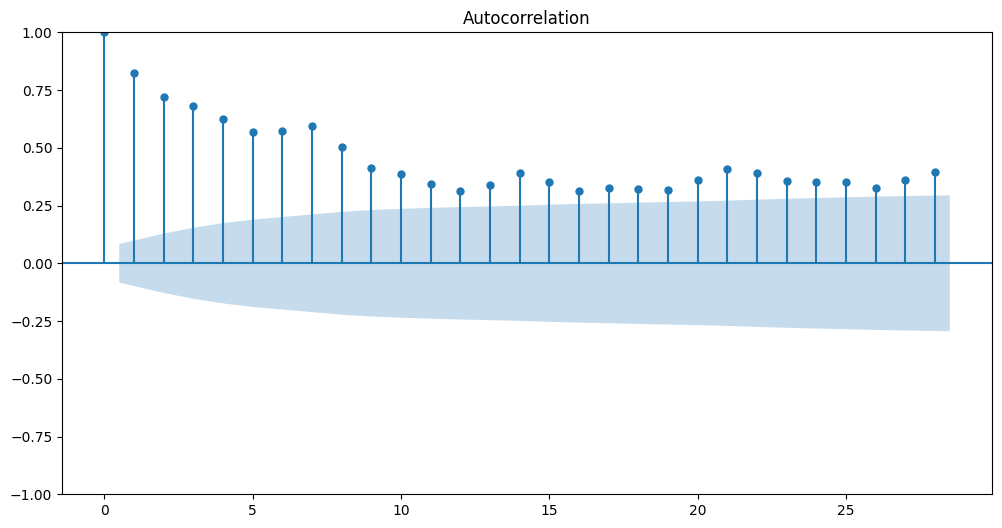

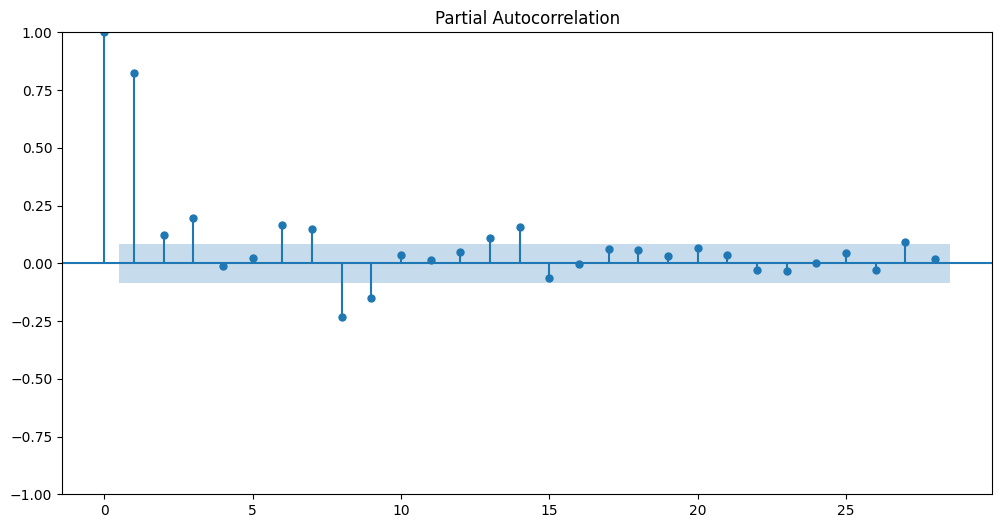

ACF and PACF for media Language


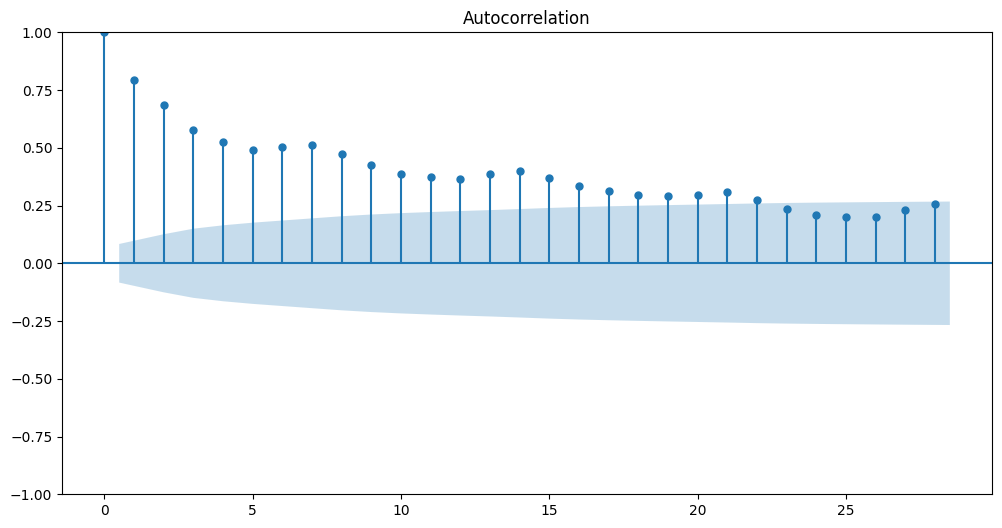

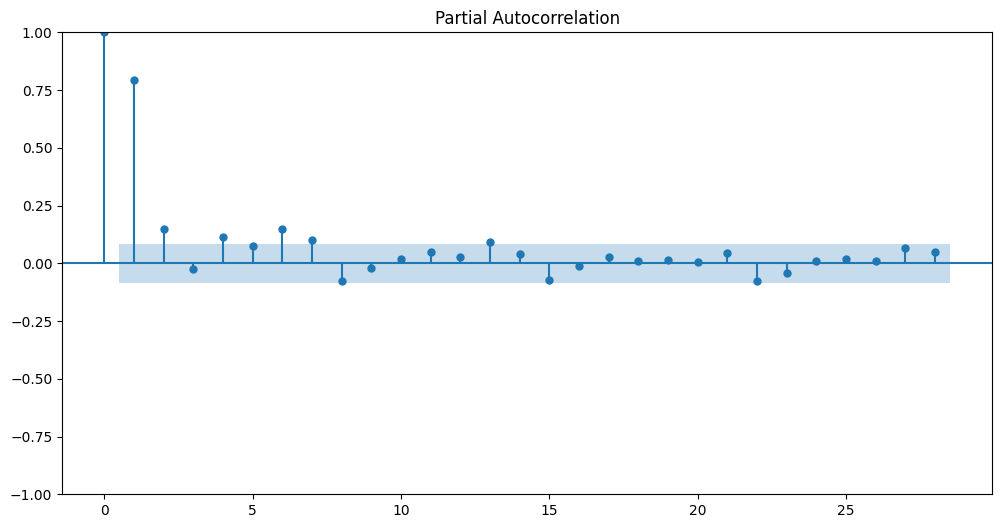

ACF and PACF for Russian Language


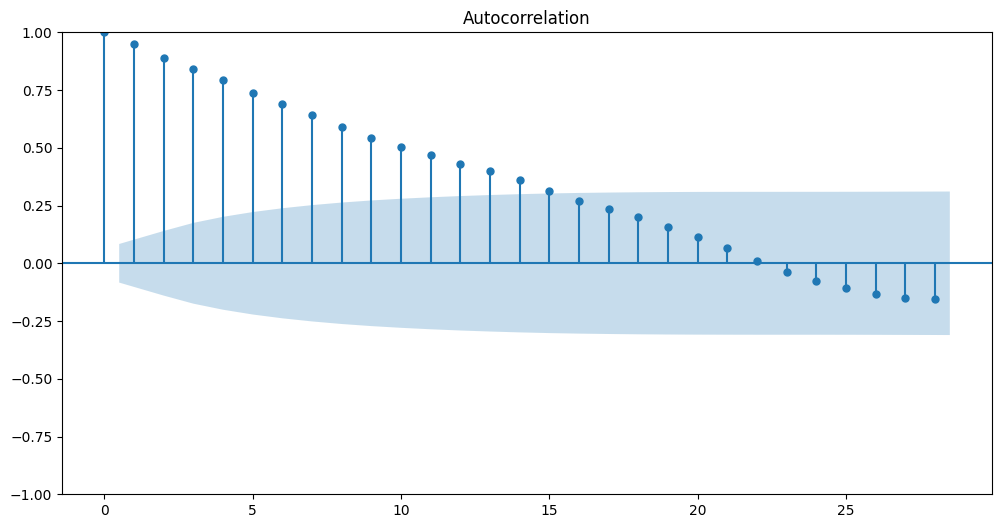

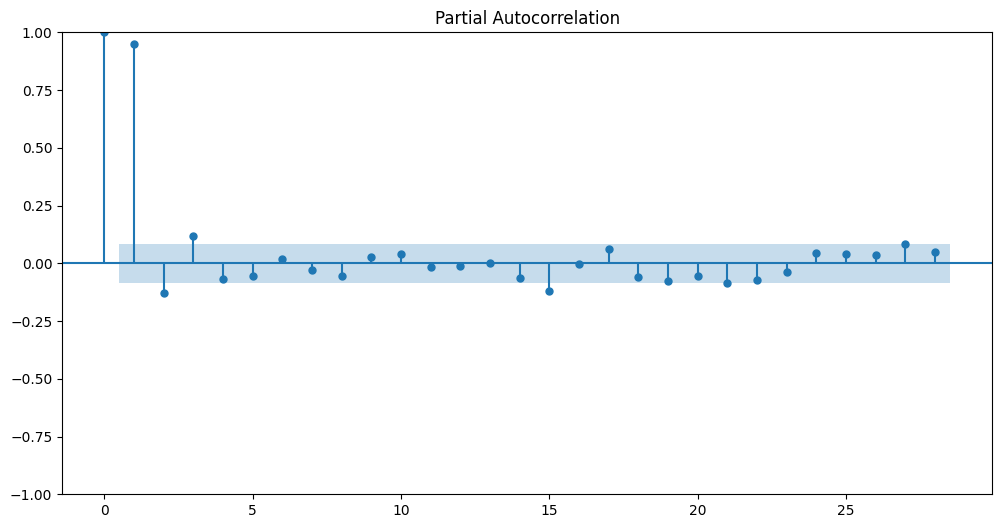

In [61]:
for lang in detrend.columns:
  print(f"ACF and PACF for {lang} Language");
  plot_acf(df3[lang]);
  plot_pacf(df3[lang]);
  plt.show()

ACF and PACF for German Language


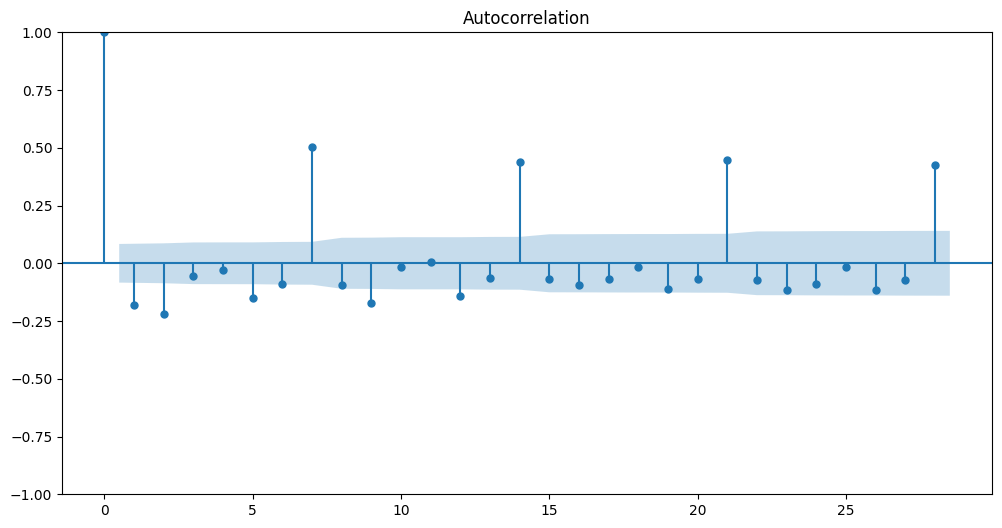

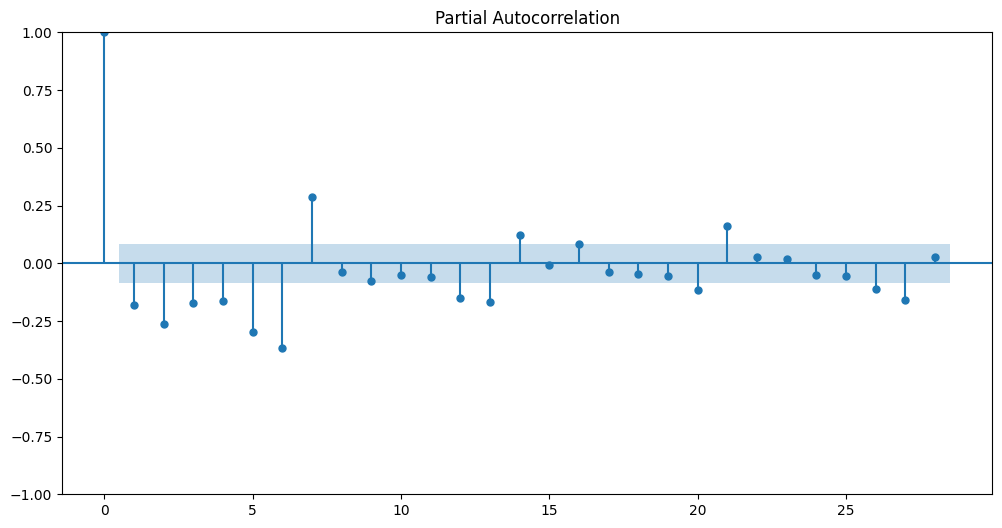

ACF and PACF for English Language


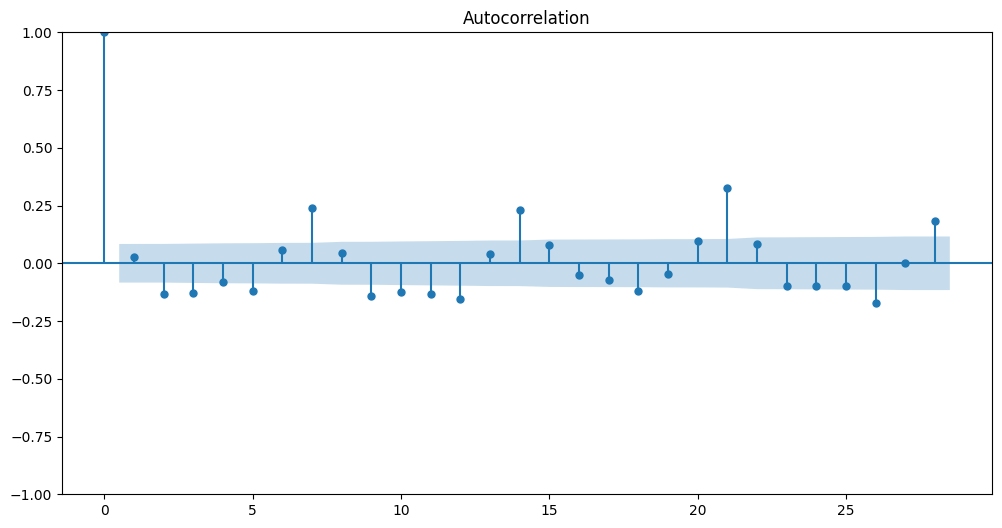

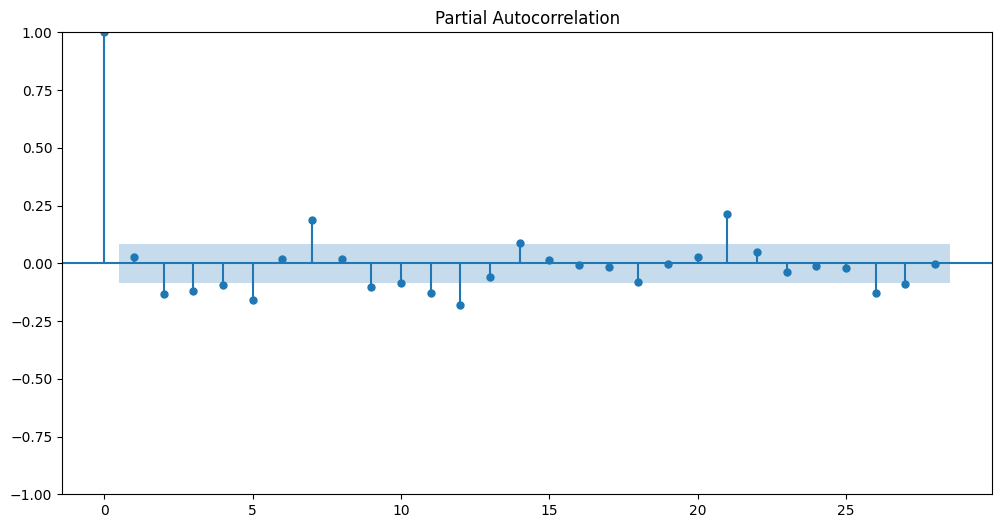

ACF and PACF for Japanese Language


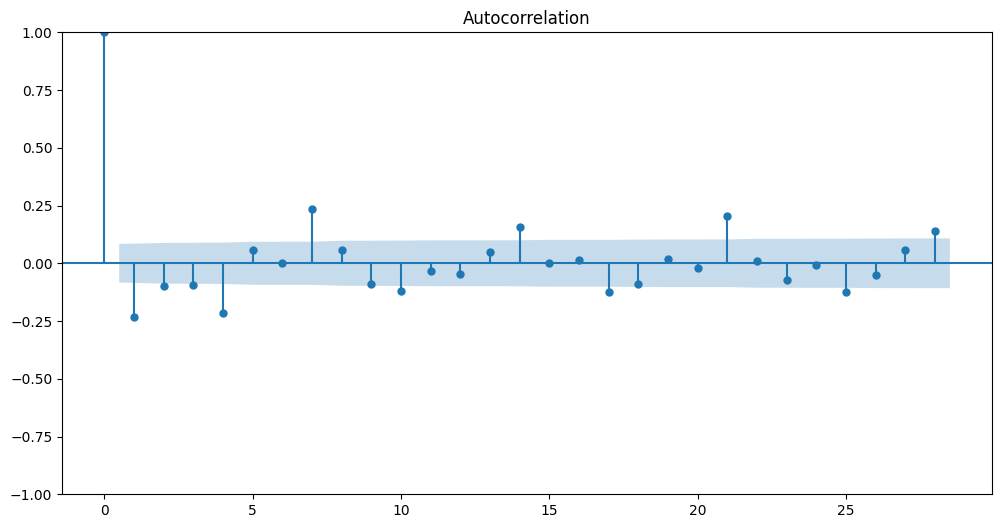

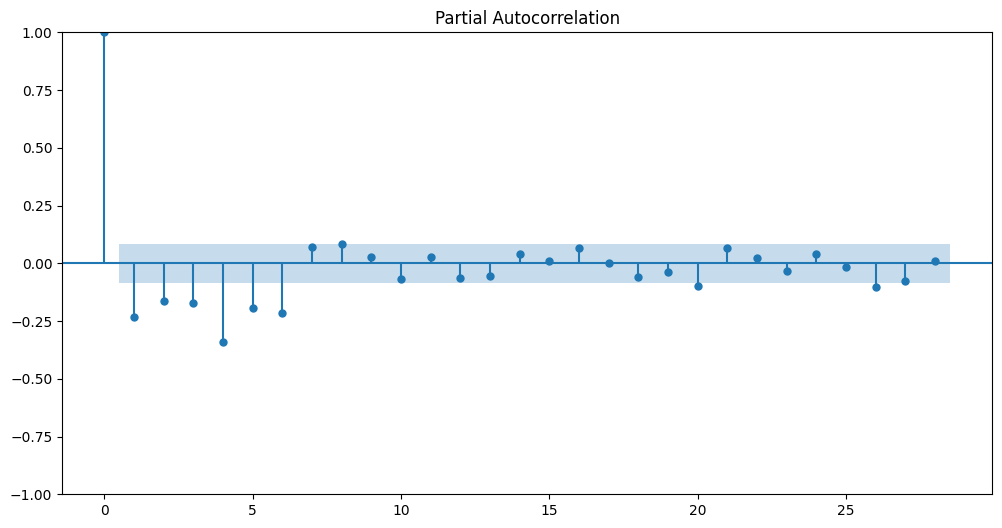

ACF and PACF for Chinese Language


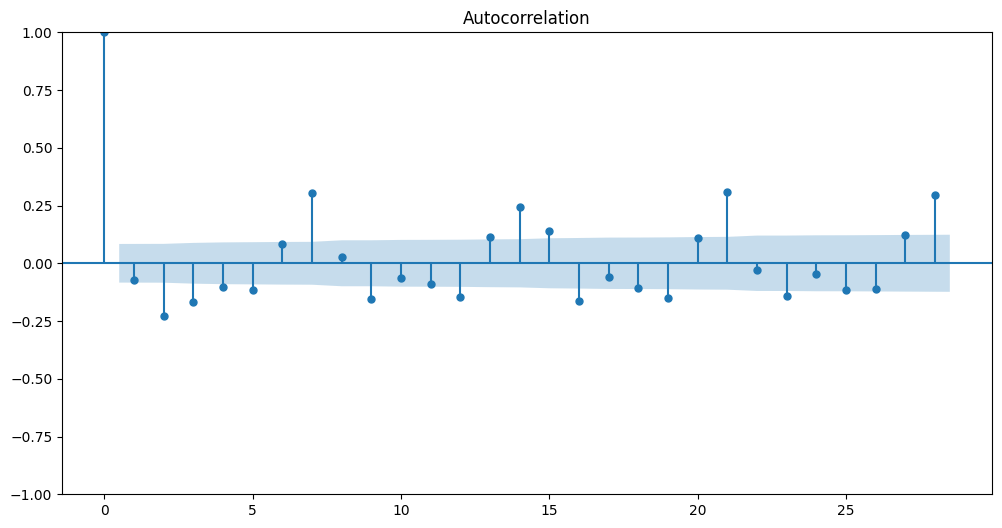

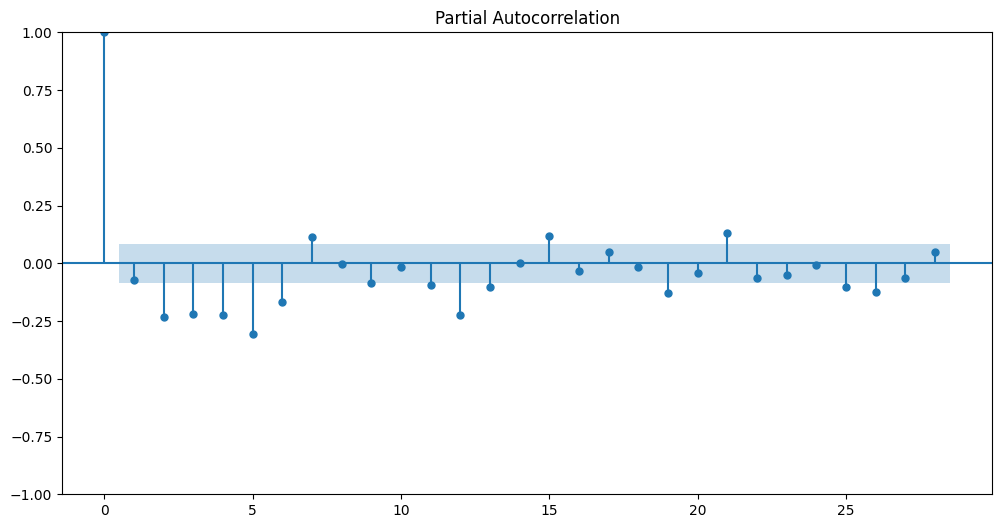

ACF and PACF for Spanish Language


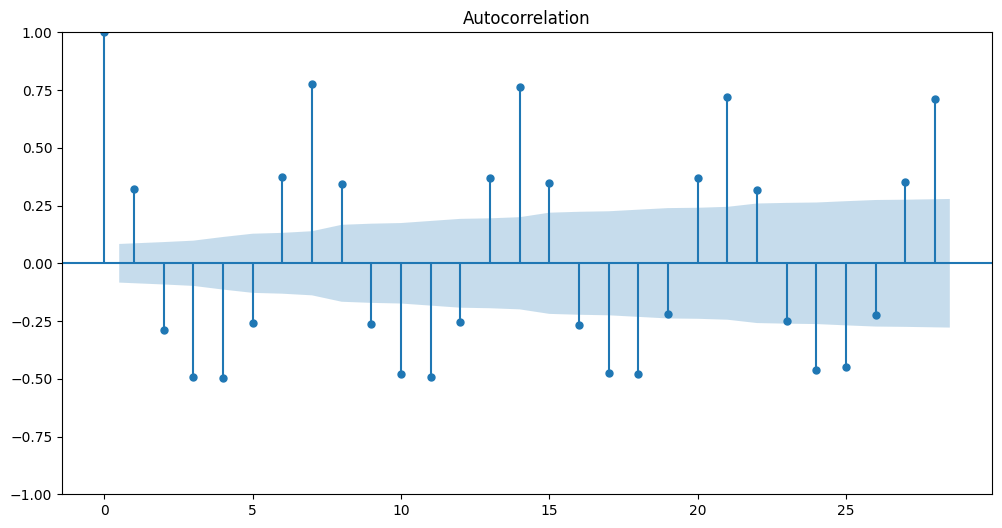

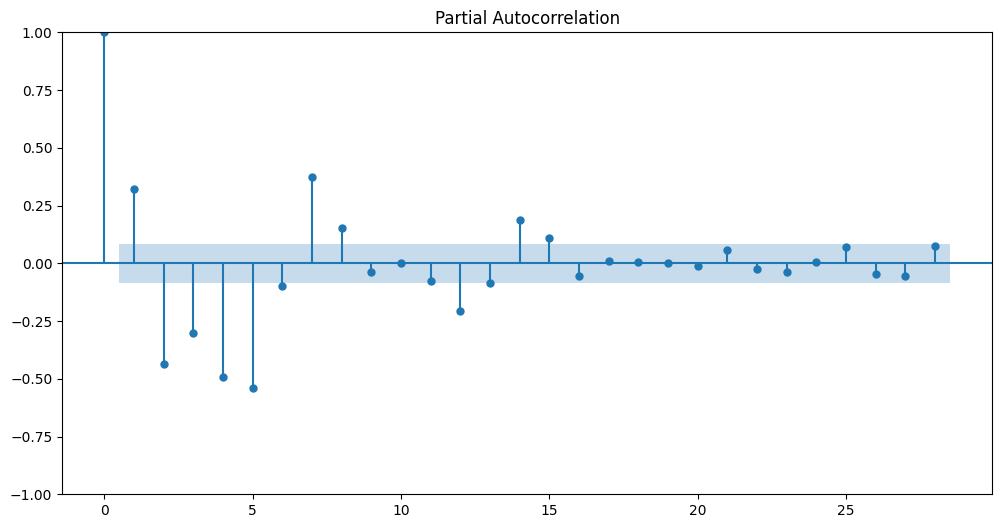

ACF and PACF for French Language


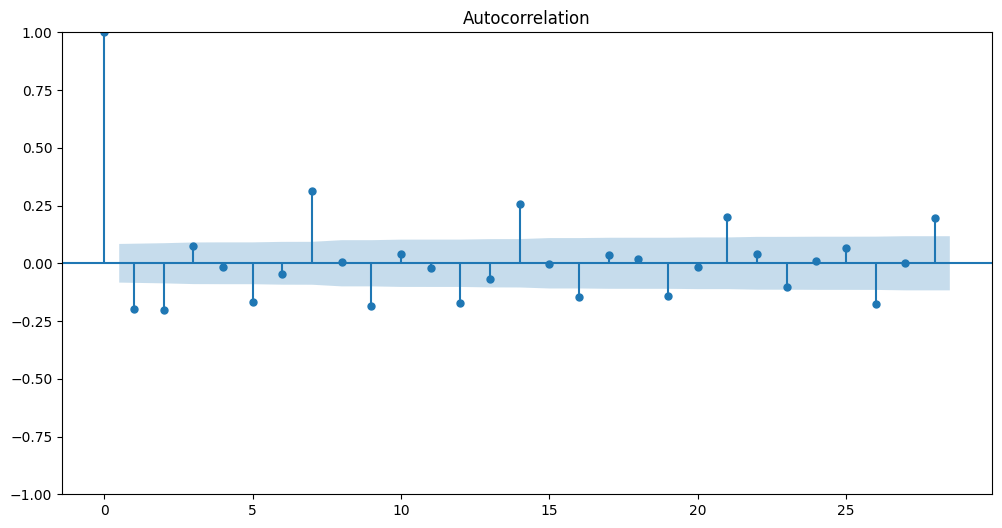

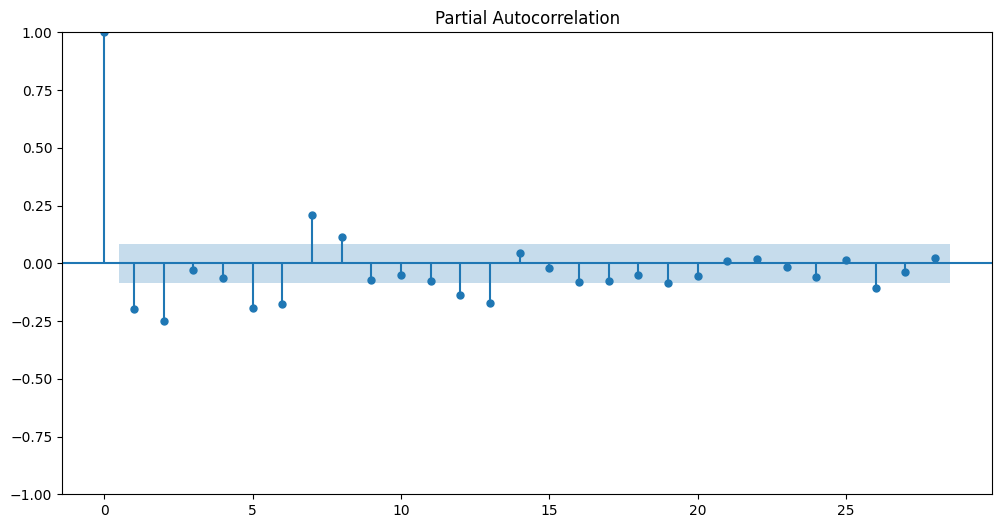

ACF and PACF for media Language


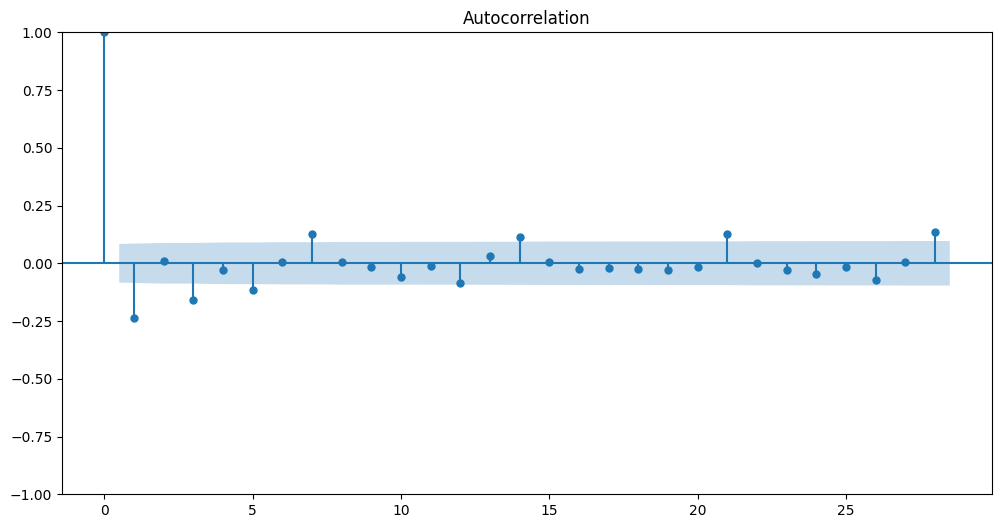

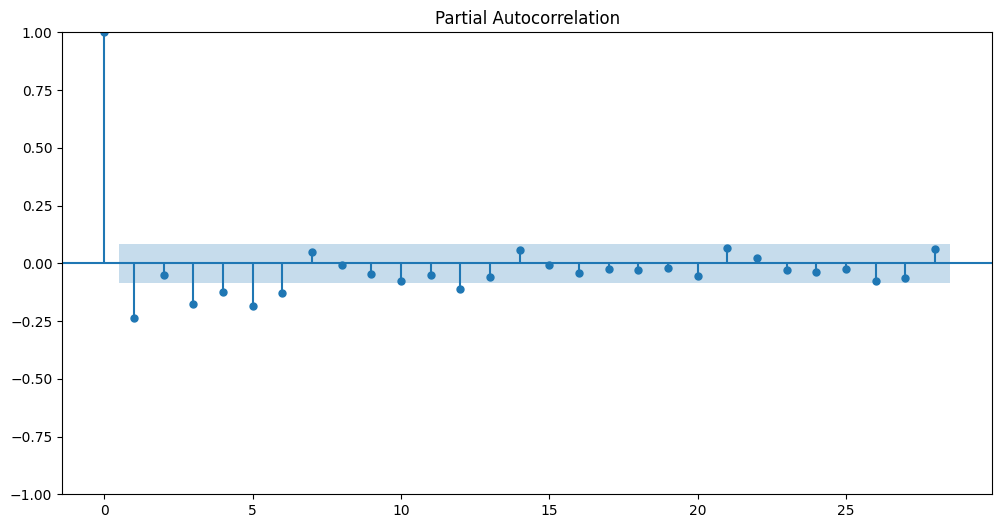

ACF and PACF for Russian Language


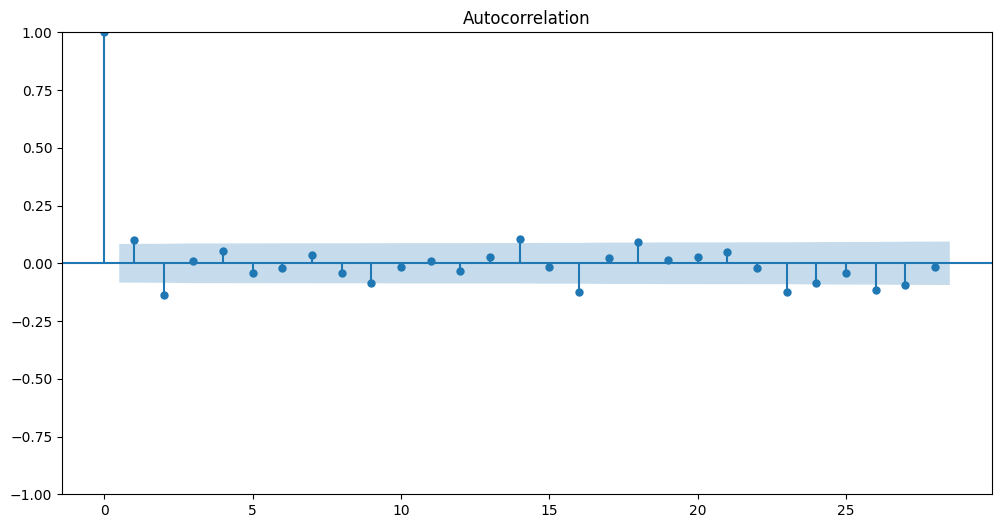

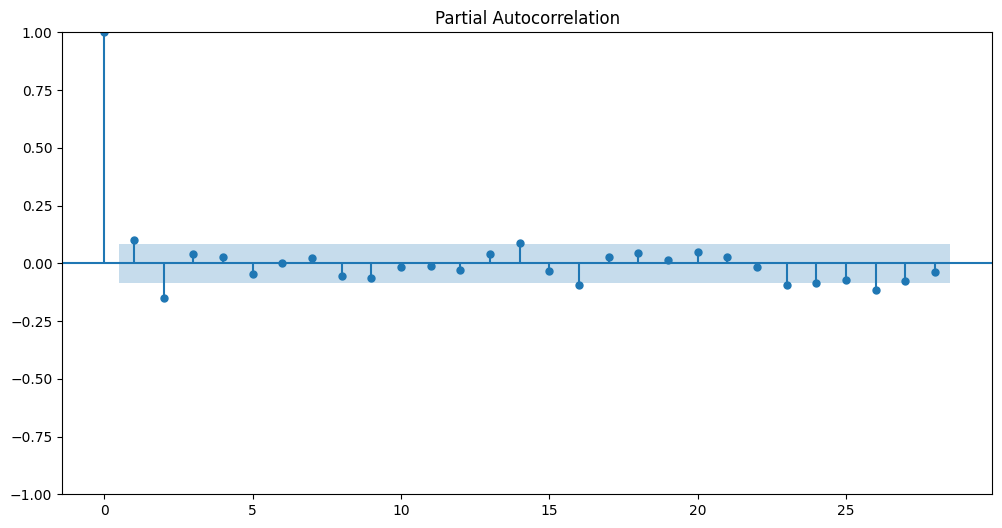

In [62]:
for lang in detrend.columns:
  print(f"ACF and PACF for {lang} Language");
  plot_acf(df3[lang].diff().dropna());
  plot_pacf(df3[lang].diff().dropna());
  plt.show()

# **3. Model Building and Evaluation**

In [63]:
df4 = df3.copy()
df4.head()

Date           German    English    Spanish    French   Japanese     media  \
2015-07-01  13.411132  85.699337  15.396839  8.914539  12.073021  1.600880   
2015-07-02  13.230595  85.403269  14.719230  8.967446  13.828733  1.671982   
2015-07-03  12.704176  81.116853  13.545160  8.640255  12.511513  1.585412   
2015-07-04  11.670462  84.411387  12.719476  9.201938  15.661715  1.369287   
2015-07-05  13.541897  87.138690  13.823122  9.041951  15.032559  1.505742   

Date         Russian   Chinese  
2015-07-01  9.638389  4.396596  
2015-07-02  9.801788  4.401151  
2015-07-03  9.097034  4.368667  
2015-07-04  8.566818  4.407916  
2015-07-05  9.108820  4.683689

## **3.1. Data splitting**

As we know, In time series forecasting, the approach to splitting the data can vary, but a common method is to split the data into training and test sets without an explicit validation set. This is because creating a validation set can lead to a significant gap between the training and test sets, which might introduce issues due to the temporal nature of the data.

To handle the model selection without a validation set, we typically use **cross-validation methods** specifically designed for time series data, such as rolling-window cross-validation. However, for simplicity, we can directly split the data into training and test sets and use a grid search on the training set to determine the best model parameters.

In [64]:
train = df4.loc[:'2016-10-31']
test = df4["2016-11-01":]
print(f'Train Shape: {train.shape} i.e {train.shape[0]*100/len(df4):.1f}% of Dataset')
print(f'Test Shape: {test.shape} i.e {test.shape[0]*100/len(df4):.1f}% of Dataset')

Train Shape: (489, 8) i.e 88.9% of Dataset
Test Shape: (61, 8) i.e 11.1% of Dataset


## **3.2. ARIMA Model**

In [65]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

**Using ACF and PACF Plot**

In [115]:
m = ARIMA(train['English'], order=(4,1,3)).fit()
pred_arima = m.forecast(steps= len(test))
performance(test["English"].values, pred_arima)

MAE : 9.28
RMSE : 14.503
MAPE: 0.071


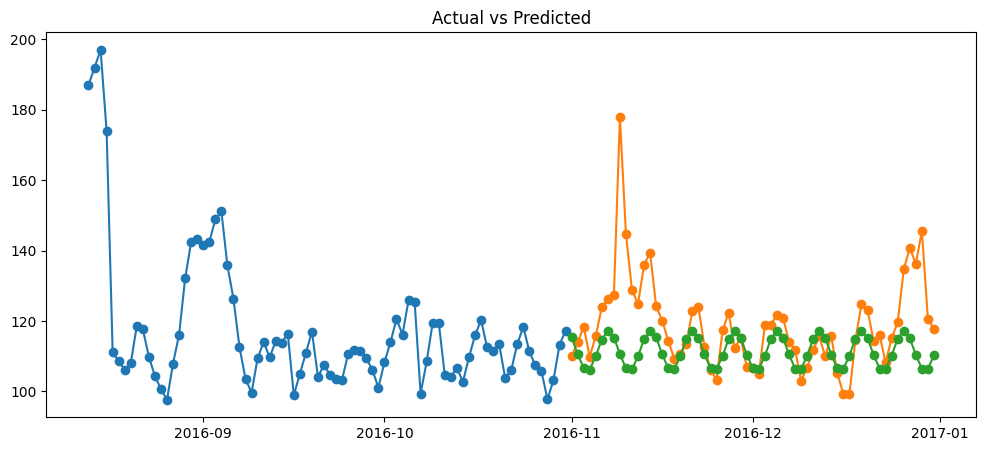

In [121]:
plt.figure(figsize= (12,5));
plt.plot(train['English'][-80:], '-o', label='Training Data');
plt.title("Actual vs Predicted");
plt.plot(test["English"], '-o', label='Actual');
plt.plot(pred_arima, '-o', label='Prediction');

**Grid search for best order (p,d,q)**

In [116]:
# Define the parameter grid
p = q = range(0, 6)
d = range(0,2)
param_grid = list(product(p, d, q))
param_grid[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

In [117]:
# 2. Finding the best order for ARIMA model
def arima_grid_search(train=train, signal = 'English', param_grid = param_grid):
  train = train[signal].to_frame()
  best_aic = np.inf
  best_order = None
  best_model = None

  for param in param_grid:
    try:
        model = ARIMA(train[signal], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except:
        continue

  return best_order, best_model

In [118]:
def fit_ARIMA(train = train, test = test, order=best_order, signal="English"):

  train = train[signal].to_frame()
  test = test[signal].to_frame()

  # 3. Fitting the best model
  best_model = ARIMA(train, order=order)
  best_model = best_model.fit()

  test['pred'] = best_model.forecast(steps=len(test), dynamic = True)

  print(performance(test[signal], test['pred']))

  test[['lower', 'upper']] = best_model.get_forecast(steps=len(test)).conf_int(0.05).values

  plt.figure(figsize= (12,6))
  plt.plot(train[signal][-80:], '-o', label='Training Data')
  plt.plot(test[signal], '-o', label='Actual')
  plt.plot(test['pred'], '-o', label='Prediction')
  plt.fill_between(test.index, test['lower'], test['upper'],
                 color='k', alpha=.15)
  plt.legend(loc='upper left', fontsize=8)

  plt.title(f'ARIMA Forecast for {signal} Language')
  plt.xlabel('Dates')
  plt.ylabel('Views')

  plt.show()

**Forecasting for English Language**

Best ARIMA order: (5, 1, 5)
MAE : 10.032
RMSE : 15.184
MAPE: 0.077
None


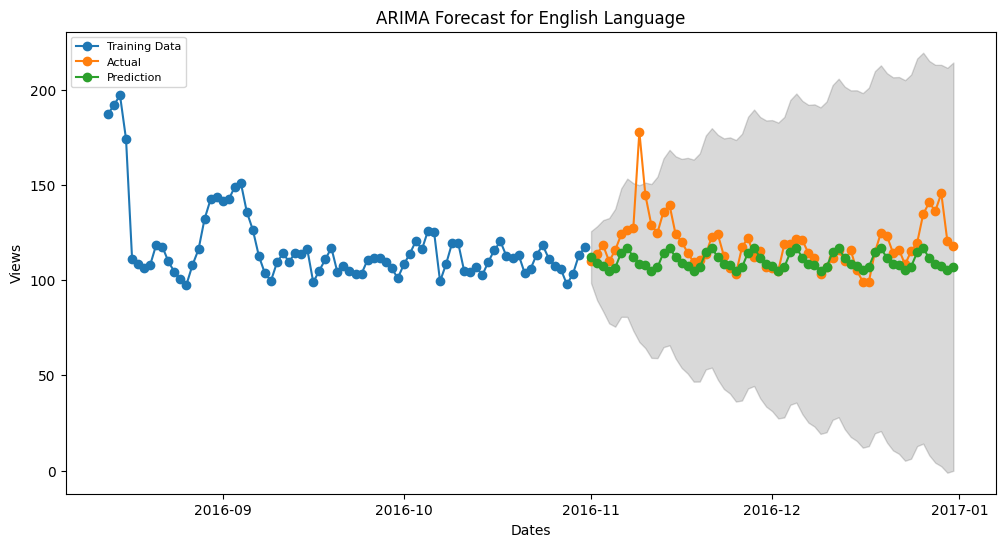

In [119]:
best_order, best_model = arima_grid_search(signal="English")
print(f'Best ARIMA order: {best_order}')
fit_ARIMA(signal="English")

We can use the above function to forecast for other language. Showcasing for Russian Language

Best ARIMA order: (5, 0, 5)
MAE : 1.005
RMSE : 1.458
MAPE: 0.069
None


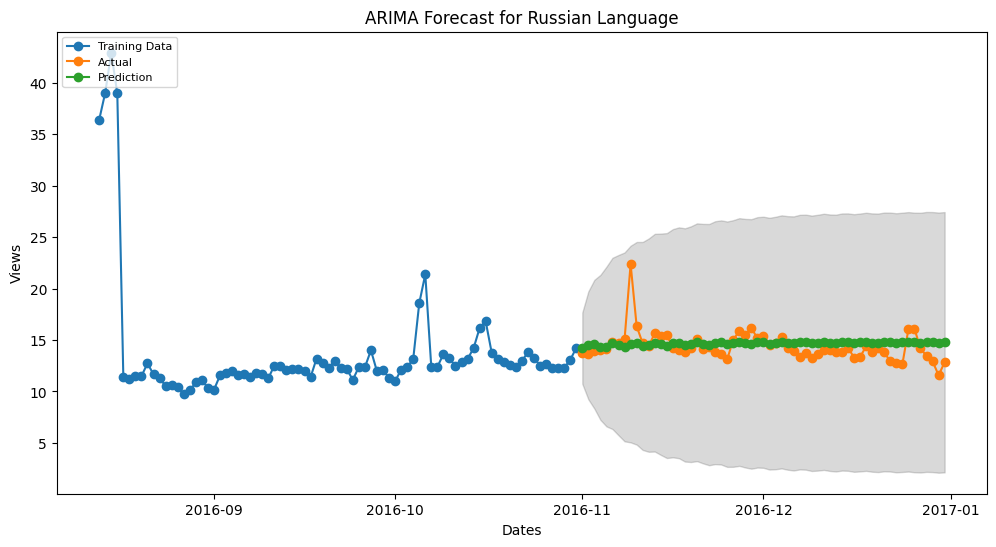

In [120]:
best_order, best_model = arima_grid_search(signal="Russian")
print(f'Best ARIMA order: {best_order}')
fit_ARIMA(signal="Russian")

## **3.3. Sarimax Model - For English Language**

In [70]:
df_en = df4["English"].copy().to_frame()
df_en['holiday'] = exog.values
df_en

English  holiday
2015-07-01   85.699337        0
2015-07-02   85.403269        0
2015-07-03   81.116853        0
2015-07-04   84.411387        0
2015-07-05   87.138690        0
...                ...      ...
2016-12-27  140.787084        1
2016-12-28  136.242892        1
2016-12-29  145.525957        1
2016-12-30  120.530669        0
2016-12-31  117.794746        0

[550 rows x 2 columns]

In [71]:
train_sm = df_en.loc[:'2016-10-31']
test_sm = df_en.loc['2016-11-01':]
train_sm.shape, test_sm.shape

((489, 2), (61, 2))

**Using ACF and PACF Plot**

In [125]:
m2 = SARIMAX(train_sm['English'], exog=train_sm['holiday'], order=(4,1,3), seasonal_order=(1,1,1,7),
                            enforce_stationarity=False, enforce_invertibility=False)
m2 = m2.fit()

In [127]:
pred_sarimax = m2.forecast(steps=len(test_sm), exog=test_sm["holiday"])
performance(test_sm["English"], pred_sarimax)

MAE : 7.311
RMSE : 9.488
MAPE: 0.061


**Random Search for Order and Seasonal Order Parameters**

In [92]:
import pandas as pd
import random
from itertools import product

# Define the parameter grid
p = q = range(0, 6)
d = range(2)
s = 7
seasonal_pdq = [(P, D, Q, s) for P in p for D in d for Q in q]
pdq = list(product(p, d, q))

# Create a DataFrame from the parameter grid
param_grid = pd.DataFrame([(p, d, q, P, D, Q, s) for (p, d, q) in pdq for (P, D, Q, s) in seasonal_pdq],
                          columns=['p', 'd', 'q', 'P', 'D', 'Q', 's'])

# Randomly sample 30 combinations from the parameter grid
rand_ind = random.sample(range(len(param_grid)), 10)
param_grid_sample = param_grid.iloc[rand_ind].reset_index(drop=True)

param_grid_sample

p  d  q  P  D  Q  s
0  4  1  5  3  0  3  7
1  0  1  0  3  0  3  7
2  2  0  4  1  0  2  7
3  4  1  3  5  1  3  7
4  5  1  1  1  0  1  7
5  2  1  5  1  0  2  7
6  3  1  3  1  1  0  7
7  5  0  1  5  1  2  7
8  4  0  5  3  0  5  7
9  3  1  5  0  1  0  7

In [93]:
# 2. Finding the best order for SARIMAX model
def sarimax_grid_search(train = train_sm['English'], exog_train = train_sm['holiday'], param_grid = param_grid):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for _, row in param_grid_sample.iterrows():
        order = (row['p'], row['d'], row['q'])
        seasonal_order = (row['P'], row['D'], row['Q'], row['s'])
        try:
            model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results

        except Exception as e:
            print(f"Error fitting SARIMAX with order {order} and seasonal order {seasonal_order}: {e}")
            continue

    return best_order, best_seasonal_order, best_model


best_order, best_seasonal_order, best_model = sarimax_grid_search()

print(f'Best SARIMAX order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')

Best SARIMAX order: (4, 1, 3)
Best seasonal order: (5, 1, 3, 7)


MAE : 9.219
RMSE : 11.353
MAPE: 0.075
None


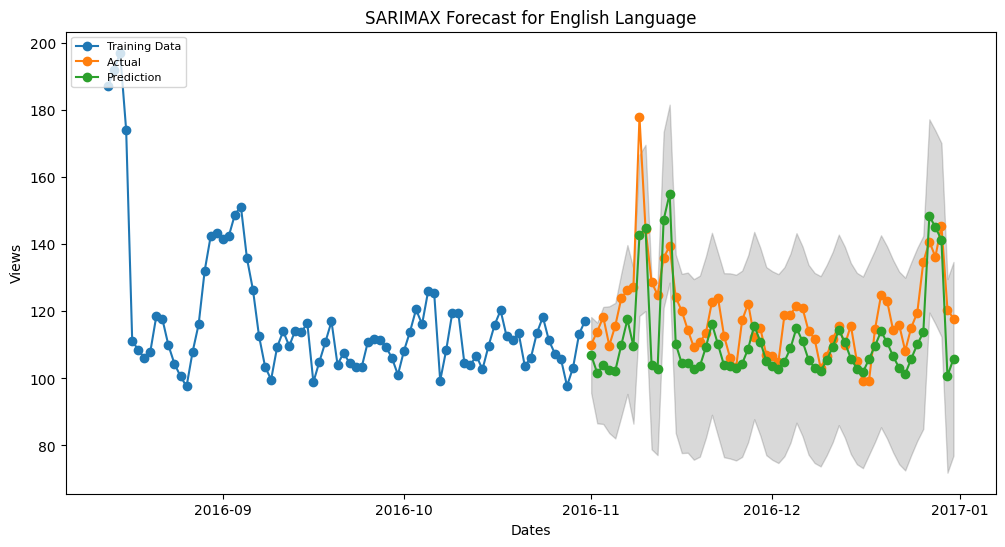

In [155]:
# Split the exogenous variable
exog_train = train_sm['holiday']
exog_test = test_sm['holiday']

# Fitting the best model
best_model = SARIMAX(train_sm['English'], exog=exog_train, order=best_order, seasonal_order=best_seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)


test_sm['pred'] = best_model.forecast(steps=len(test_sm), exog=exog_test)
print(performance(test['English'], test_sm['pred']))
test_sm[['lower', 'upper']] = best_model.get_forecast(steps=len(test_sm),exog=exog_test).conf_int(0.05).values

plt.figure(figsize=(12, 6))
plt.plot(train_sm['English'][-80:], '-o', label='Training Data')
plt.plot(test_sm["English"], '-o', label='Actual')
plt.plot(test_sm["pred"], '-o', label='Prediction')
plt.fill_between(test_sm.index, test_sm['lower'], test_sm['upper'],
                color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)

plt.title(f'SARIMAX Forecast for English Language')
plt.xlabel('Dates')
plt.ylabel('Views')
plt.show()

## **3.4. Prophet Model**

In [128]:
df5 = df4.copy()

In [129]:
df6 = pd.DataFrame()
df6['ds'] = df5.index
df6['y'] = df5['English'].values
df6['holiday'] = exog['Exog']
df6

ds           y  holiday
0   2015-07-01   85.699337        0
1   2015-07-02   85.403269        0
2   2015-07-03   81.116853        0
3   2015-07-04   84.411387        0
4   2015-07-05   87.138690        0
..         ...         ...      ...
545 2016-12-27  140.787084        1
546 2016-12-28  136.242892        1
547 2016-12-29  145.525957        1
548 2016-12-30  120.530669        0
549 2016-12-31  117.794746        0

[550 rows x 3 columns]

In [130]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       550 non-null    datetime64[ns]
 1   y        550 non-null    float64       
 2   holiday  550 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.0 KB


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8teequmg/joupkiyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8teequmg/c14db2jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88511', 'data', 'file=/tmp/tmp8teequmg/joupkiyx.json', 'init=/tmp/tmp8teequmg/c14db2jj.json', 'output', 'file=/tmp/tmp8teequmg/prophet_model92_ew8hx/prophet_model-20240519174009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


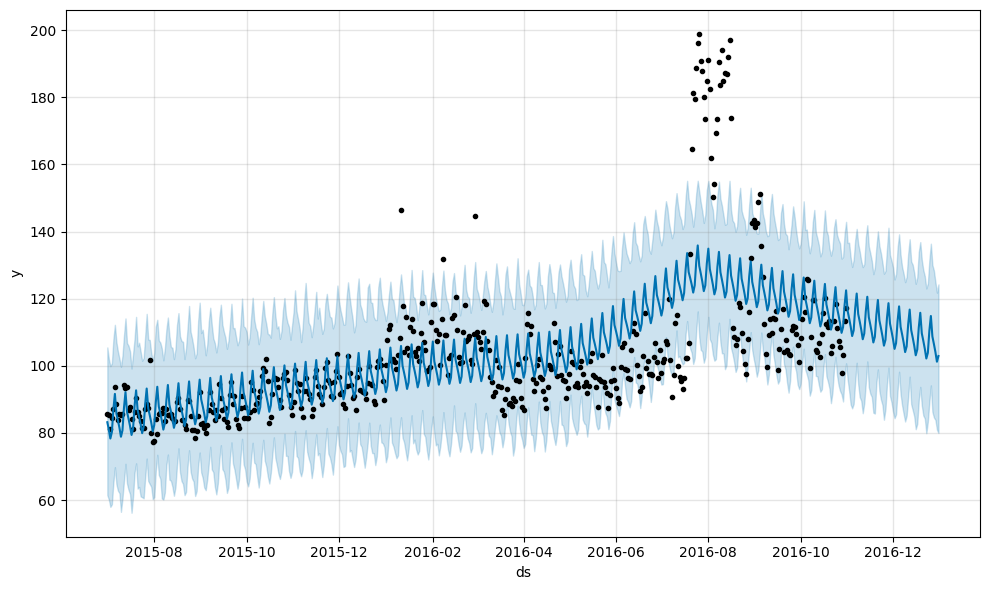

In [131]:
# from fbprophet import Prophet
m = Prophet()
m.fit(df6[['ds', 'y']][:-61]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=61,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

In [132]:
forecast.tail(4)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
546 2016-12-28  106.975887   84.635588  128.389091   104.185494   109.708996   
547 2016-12-29  106.839378   83.892281  124.986921   103.938923   109.630668   
548 2016-12-30  106.702869   80.994571  121.807410   103.685465   109.552227   
549 2016-12-31  106.566360   80.005099  124.271603   103.476816   109.478865   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
546       -0.460161             -0.460161             -0.460161 -0.460161   
547       -2.729462             -2.729462             -2.729462 -2.729462   
548       -5.471885             -5.471885             -5.471885 -5.471885   
549       -3.634501             -3.634501             -3.634501 -3.634501   

     weekly_lower  weekly_upper  multiplicative_terms  \
546     -0.460161     -0.460161                   0.0   
547     -2.729462     -2.729462                   0.0   
548     -5.471885     -5.471885                   0.0   
549     -3.634501     -3.634501                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
546                         0.0                         0.0  106.515726  
547                         0.0                         0.0  104.109916  
548                         0.0                         0.0  101.230984  
549                         0.0                         0.0  102.931859

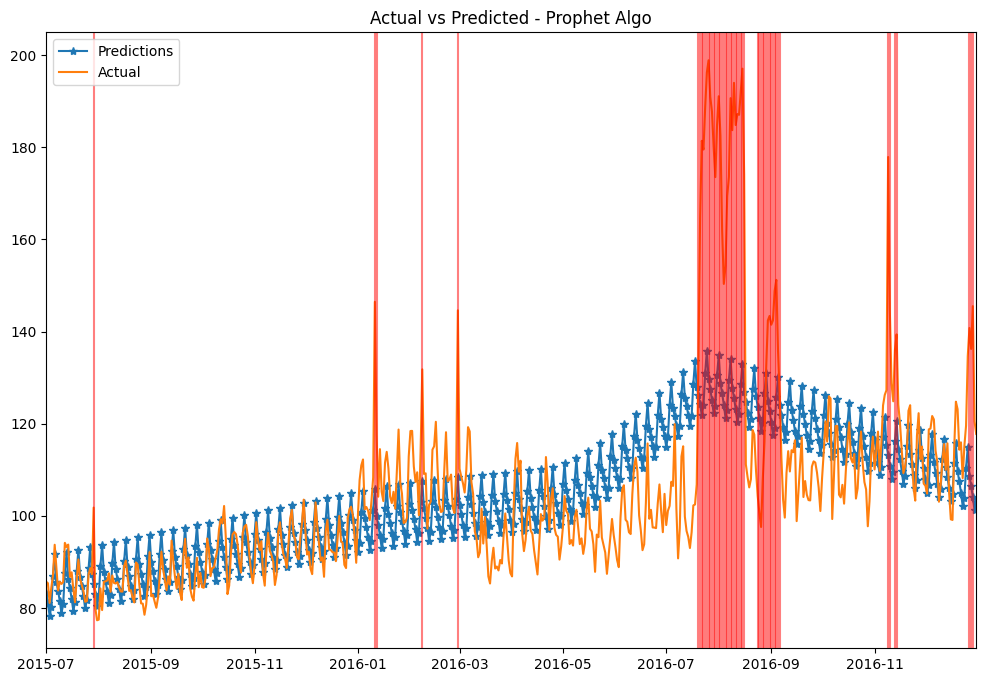

In [133]:
plt.figure(figsize=(12,8))
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df6['ds'], df6['y'], label = 'Actual')
for x in df6.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2015-07-01'), pd.to_datetime('2016-12-31'))
plt.title(f'Actual vs Predicted - Prophet Algo')
plt.legend();

In [134]:
performance(df6['y'][:-61],forecast['yhat'][:-61])

MAE : 10.439
RMSE : 16.413
MAPE: 0.089


## **3.5. Comparision**

Best on the Performance We can see that SARIMAX model is the best suited model.

- SARIMAX is performing better in comparision to ARIMA or FB prophet, with MAPE = 0.059.

- We can easily see that there is Seasonality and Trend in the data.

- Differencing of 1 level is required for English Language.

# **4. Results Interpretation & Stakeholder Presentation**

## **4.1. Understand the Business Context**

Ad Ease aims to leverage advanced time series analysis and forecasting techniques to enhance its ad placement services. By understanding view patterns across a vast number of Wikipedia pages and accounting for regional and language-specific nuances, Ad Ease can provide clients with optimized advertising strategies that drive engagement and reduce costs. Below are the three main objectives.

- Targeted Advertising: More accurate predictions lead to better-targeted ads, increasing the chances of engagement.
- Cost Efficiency: Optimized ad placements reduce wasted spend on less effective ads, maximizing ROI.
- Localized Insights: Clients receive data tailored to their regional markets, improving the relevance and effectiveness of their advertising campaigns.

## **4.2. Interpreting multiple time series forecasts**

- Number of Pages and views/visits for English Pages are higher comapared to other languages.
- The ARIMA model's result are good but SARIMAX model's improves the performace by incorporating the exogenous variable
- We have notices weekly seasionality
- FBProphet doesn't performed better in our case compared to the SARIMAX or ARIMA models

## **4.3. Visual Representations**



 English language is a clear winner. Maximum advertisement should be done on
 English pages. Their MAPE is low & mean visits are high.

 Chinese language has lowest number of visits. Advertisements on these pages
 should be avoided unless business has specific marketing strategy for Chinese
 populations.

 Russian language pages have decent number of visits and low MAPE. If used
 properly, these pages can result in maximum conversion.

 Spanish language has second highest number of visits but their MAPE is highest.
 There is a possibility advertisements on these pages won't reach the final people.

 French, German & Japenese have medium level of visits & medium MAPE levels.

 Depending on target customers advertisements should be run on these pages.

# **Questionnaire**

## 1. **Defining the problem statements and where can this and modifications of this be used?**

<font type = "Georgia" >

### **Problem Statements**

1. **Time Series Forecasting for Wikipedia Page Views:**
   - **Objective:** Predict the daily views for each of the 145,000 Wikipedia pages over a future period to optimize ad placements.
   - **Application:** Ensure ad placements align with periods of high traffic to maximize visibility and engagement.

2. **Regional and Language-Based Traffic Analysis:**
   - **Objective:** Analyze and forecast the views for Wikipedia pages across different languages to provide region-specific ad placement strategies.
   - **Application:** Tailor ad campaigns to target specific geographic regions and language groups, improving the relevance and effectiveness of ads.

3. **Seasonality and Trend Detection:**
   - **Objective:** Identify seasonal patterns and long-term trends in Wikipedia page views to better understand user behavior.
   - **Application:** Align ad campaigns with predictable peaks in page views to enhance engagement and return on investment (ROI).

4. **Anomaly Detection in Page Views:**
   - **Objective:** Detect sudden spikes or drops in page views that could indicate viral content or issues with the data.
   - **Application:** Quickly respond to viral trends by placing ads on suddenly popular pages or investigate and correct data anomalies.

### **Potential Uses and Modifications**

1. **Customized Ad Placement Recommendations:**
   - **Usage:** Use the forecasted view data to create a recommendation system for clients, suggesting optimal times and pages for ad placement based on predicted traffic.
   - **Modification:** Incorporate client-specific metrics (e.g., engagement rate, conversion rate) into the recommendation algorithm for more personalized suggestions.

2. **Cross-Platform Ad Optimization:**
   - **Usage:** Extend the forecasting model to other platforms (e.g., news sites, blogs) to provide a holistic ad placement strategy.
   - **Modification:** Integrate data from multiple sources and apply multi-platform machine learning models to optimize ad spend across various digital channels.

3. **Real-Time Ad Bidding Systems:**
   - **Usage:** Implement the forecasting model in real-time bidding (RTB) systems to dynamically bid for ad spaces based on predicted view counts.
   - **Modification:** Enhance the model with real-time data feeds and develop algorithms for instantaneous decision-making in ad auctions.

4. **Content Performance Analysis:**
   - **Usage:** Provide clients with insights on which topics or content types are likely to gain more traction, helping them create more effective content.
   - **Modification:** Include natural language processing (NLP) techniques to analyze the content of Wikipedia pages and correlate content characteristics with view counts.

5. **Budget Allocation and Campaign Planning:**
   - **Usage:** Advise clients on the optimal allocation of their advertising budgets based on forecasted page views to maximize ROI.
   - **Modification:** Develop an interactive dashboard that allows clients to simulate different budget scenarios and their impact on ad performance.

6. **Localization and Internationalization Strategies:**
   - **Usage:** Help clients develop strategies for entering new markets by providing data on Wikipedia page views in different languages and regions.
   - **Modification:** Combine page view data with other market indicators (e.g., economic data, cultural trends) to offer comprehensive market entry strategies.

### **Conclusion**

By leveraging the time series forecasting and analysis of Wikipedia page views, Ad Ease can significantly enhance its ad placement strategies, offering more value to clients. The applications of this data-driven approach range from personalized ad recommendations to real-time bidding and content performance analysis, each providing a unique advantage in the competitive field of digital advertising. Modifying and extending these methodologies can open new opportunities for optimization and growth, aligning with the company’s mission to maximize clicks at minimum cost.

## **2. Write 3 inferences you made from the data visualizations**

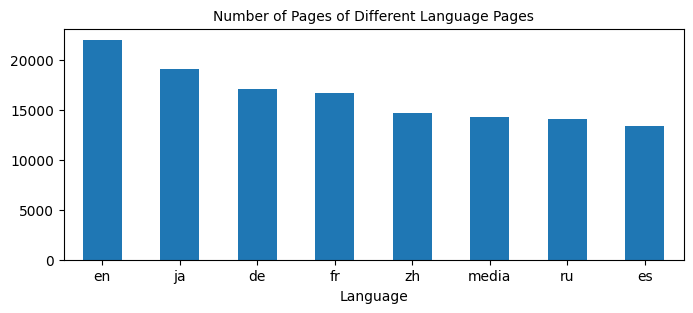

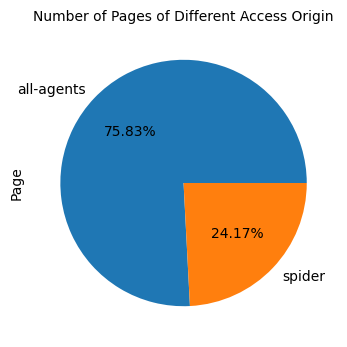

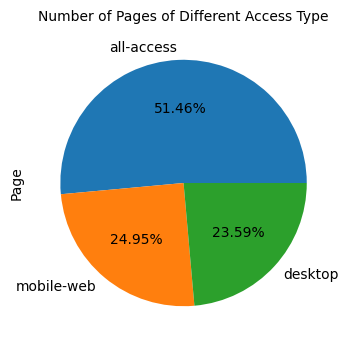

In [143]:
plt.figure(figsize=(8,3))
df.groupby(["Language"])["Page"].count().sort_values(ascending = False).plot(kind="bar")
plt.title("Number of Pages of Different Language Pages", fontsize=10);
plt.xticks(rotation = 0)
plt.show()

plt.figure(figsize=(4,4))
df.groupby(["accessOrigin"])["Page"].count().sort_values(ascending = False).plot(kind="pie", autopct="%.2f%%")
plt.title("Number of Pages of Different Access Origin", fontsize=10);
plt.xticks(rotation = 0)
plt.show()

plt.figure(figsize=(4,4))
df.groupby(["accessType"])["Page"].count().sort_values(ascending = False).plot(kind="pie", autopct="%.2f%%")
plt.title("Number of Pages of Different Access Type", fontsize=10);
plt.xticks(rotation = 0)
plt.show()

In [144]:
df['Language'].value_counts(normalize=True)

Language
en       0.167837
ja       0.145348
de       0.129914
fr       0.127098
zh       0.111899
media    0.108733
ru       0.107470
es       0.101701
Name: proportion, dtype: float64

1. There are 7 Languages found based on data provided. English has highest number of pages followed by Japense, German & French.

2. There are 3 Access types : All-access(51.4%), mobile-web (24.9%) and desktop(23.6%).

3. There are 2 Access-origins: all-agents (75.8%) and spider (24.2%).

4. English language has maximum visits (16.7%). Maximum advertisement should be done on English pages. Mean visits are high.

5. Chinese language has lowest number of visits. Advertisements on these pages
 should be avoided unless business has specific marketing strategy for Chinese
 populations.

6. Russian language pages have decent number of visits and low MAPE. If used
 properly, these pages can result in maximum conversion.
 Spanish language has second highest number of visits but their MAPE is highest.

7. There is a possibility advertisements on these pages won't reach the final people.

8. French, German & Japenese have medium level of visits & medium MAPE levels.
 Depending on target customers advertisements should be run on these pages.


## **3. What does the decomposition of series do?**

The decomposition of a time series is a process used to break down a time series dataset into its constituent components to better understand and analyze the underlying patterns. This is particularly useful in the context of forecasting and anomaly detection. Typically, a time series can be decomposed into three main components:

1. **Trend Component:**
   - **Description:** Represents the long-term progression or direction of the data. It indicates the overall upward, downward, or stable movement in the series over time.
   - **Usage:** Identifying the trend helps in understanding the general direction in which the data is moving, which is crucial for long-term forecasting.

2. **Seasonal Component:**
   - **Description:** Captures the repeating short-term cycle or pattern in the data. This could be daily, weekly, monthly, or yearly cycles.
   - **Usage:** Understanding the seasonal component is important for predicting periodic fluctuations and aligning strategies with these regular patterns.

3. **Residual (or Irregular) Component:**
   - **Description:** Represents the random noise or irregular fluctuations in the data that cannot be attributed to the trend or seasonal components.
   - **Usage:** Analyzing the residual component can help identify anomalies or outliers and assess the variability in the data not explained by trend or seasonality.

### Methods of Decomposition

There are several methods to decompose a time series, with the two most common being:

1. **Additive Decomposition:**
   - **Model:** \( Y_t = T_t + S_t + R_t \)
   - **Application:** Used when the seasonal variations are roughly constant over time, and the overall data variations can be described as a sum of the components.

2. **Multiplicative Decomposition:**
   - **Model:** \( Y_t = T_t \times S_t \times R_t \)
   - **Application:** Used when the seasonal variations change proportionally with the level of the series, making the components multiplicative rather than additive.

In the context of Ad Ease, decomposing the time series of Wikipedia page views can help in understanding when and why certain pages receive more views, thereby optimizing ad placements based on trends and seasonal peaks. This decomposition will also aid in predicting future view patterns, allowing for more effective ad campaign planning and budget allocation.

## **4. What level of differencing gave you a stationary series?**

In [145]:
df3.head()

Date           German    English    Spanish    French   Japanese     media  \
2015-07-01  13.411132  85.699337  15.396839  8.914539  12.073021  1.600880   
2015-07-02  13.230595  85.403269  14.719230  8.967446  13.828733  1.671982   
2015-07-03  12.704176  81.116853  13.545160  8.640255  12.511513  1.585412   
2015-07-04  11.670462  84.411387  12.719476  9.201938  15.661715  1.369287   
2015-07-05  13.541897  87.138690  13.823122  9.041951  15.032559  1.505742   

Date         Russian   Chinese  
2015-07-01  9.638389  4.396596  
2015-07-02  9.801788  4.401151  
2015-07-03  9.097034  4.368667  
2015-07-04  8.566818  4.407916  
2015-07-05  9.108820  4.683689

In [146]:
## Test for stationarity
for lang in df3.columns:
  print(lang, end=" : ")
  adf_test(df3[lang])

German : Sequence is not stationary
English : Sequence is not stationary
Spanish : Sequence is stationary
French : Sequence is stationary
Japanese : Sequence is not stationary
media : Sequence is stationary
Russian : Sequence is stationary
Chinese : Sequence is not stationary


In [147]:
df_diff = df3.diff().dropna()
for lang in df_diff.columns:
  print(lang, end=" : ")
  adf_test(df_diff[lang])

German : Sequence is stationary
English : Sequence is stationary
Spanish : Sequence is stationary
French : Sequence is stationary
Japanese : Sequence is stationary
media : Sequence is stationary
Russian : Sequence is stationary
Chinese : Sequence is stationary


In the context of Ad Easy, we have got stationary time series in one level of differencing. Which is inline with the usual context as we get stationary in one or two levels.

## **5. Difference between arima, sarima & sarimax.**

ARIMA, SARIMA, and SARIMAX are all models used in time series forecasting, but they differ in their capabilities and the types of data they can handle. Here’s a detailed comparison:

### ARIMA (AutoRegressive Integrated Moving Average)

**Components:**
- **AutoRegressive (AR) part:** Involves regressing the variable on its own lagged (previous) values.
- **Integrated (I) part:** Involves differencing the data to make it stationary.
- **Moving Average (MA) part:** Involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past.

**Model Notation:**
- **ARIMA(p, d, q)** where:
  - \( p \): Number of lag observations included in the model (AR part).
  - \( d \): Number of times that the raw observations are differenced (I part).
  - \( q \): Size of the moving average window (MA part).

**Usage:**
- Used for time series data that do not exhibit seasonality.

### SARIMA (Seasonal ARIMA)

**Components:**
- **Seasonal ARIMA:** Extends ARIMA to support seasonality in the time series data.

**Model Notation:**
- **SARIMA(p, d, q)(P, D, Q, s)** where:
  - \( p, d, q \): Non-seasonal ARIMA parameters.
  - \( P \): Number of seasonal autoregressive terms.
  - \( D \): Number of seasonal differences.
  - \( Q \): Number of seasonal moving average terms.
  - \( s \): Length of the seasonal cycle.

**Usage:**
- Used for time series data with a seasonal pattern.

### SARIMAX (Seasonal ARIMA with eXogenous variables)

**Components:**
- **SARIMAX:** Combines SARIMA with the ability to include exogenous variables (external predictors).

**Model Notation:**
- **SARIMAX(p, d, q)(P, D, Q, s) with exogenous regressors**

**Usage:**
- Used for time series data with seasonal patterns and external variables that can influence the model.

### Key Differences

1. **Seasonality:**
   - **ARIMA:** Does not handle seasonality.
   - **SARIMA:** Handles seasonality by incorporating seasonal AR, differencing, and MA terms.
   - **SARIMAX:** Handles seasonality and also includes exogenous variables.

2. **Exogenous Variables:**
   - **ARIMA and SARIMA:** Do not include exogenous variables.
   - **SARIMAX:** Includes exogenous variables that can provide additional predictive power.

3. **Complexity:**
   - **ARIMA:** Simplest among the three, used for non-seasonal data.
   - **SARIMA:** More complex due to additional seasonal components.
   - **SARIMAX:** Most complex, incorporating both seasonal components and exogenous predictors.

### Practical Applications

- **ARIMA:** Best suited for data without seasonal patterns. Example: Monthly sales data without a clear seasonal trend.
- **SARIMA:** Suitable for data with a clear seasonal pattern. Example: Monthly temperature data showing annual seasonality.
- **SARIMAX:** Useful when external factors (exogenous variables) can influence the time series. Example: Forecasting retail sales considering advertising spend as an exogenous variable.

### Example Implementations

#### ARIMA:
```python
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data, order=(p, d, q))
fit = model.fit()
forecast = fit.forecast(steps=forecast_horizon)
```

#### SARIMA:
```python
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))
fit = model.fit()
forecast = fit.forecast(steps=forecast_horizon)
```

#### SARIMAX:
```python
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exogenous_data)
fit = model.fit()
forecast = fit.forecast(steps=forecast_horizon, exog=exogenous_data_forecast)
```

In summary, choosing between ARIMA, SARIMA, and SARIMAX depends on whether your data has seasonality and whether there are exogenous factors that should be considered in your forecasting model.

## **6. Compare the number of views in different languages**


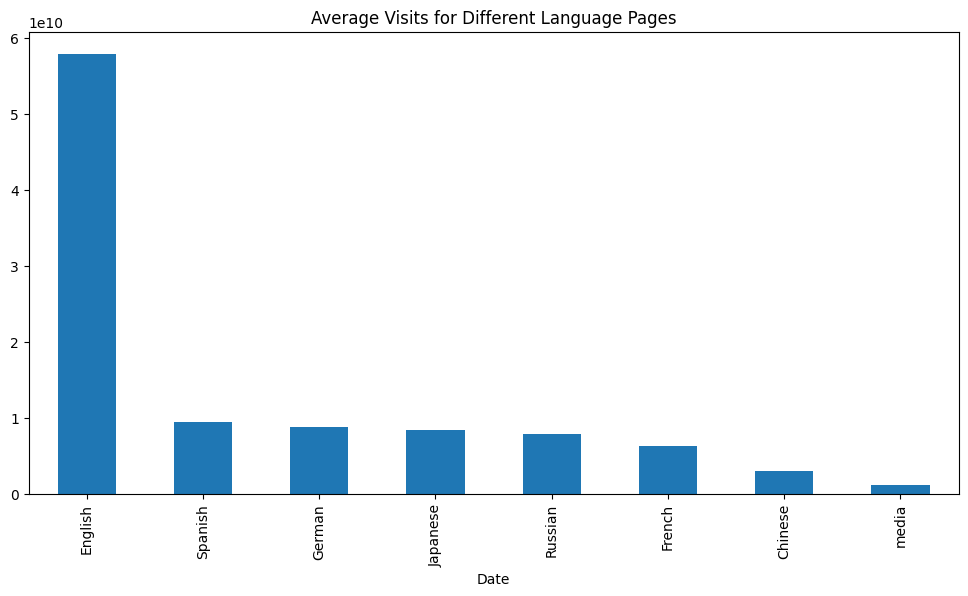

In [148]:
df2.sum().sort_values(ascending=False).plot(kind='bar');
plt.title("Average Visits for Different Language Pages");
plt.show()

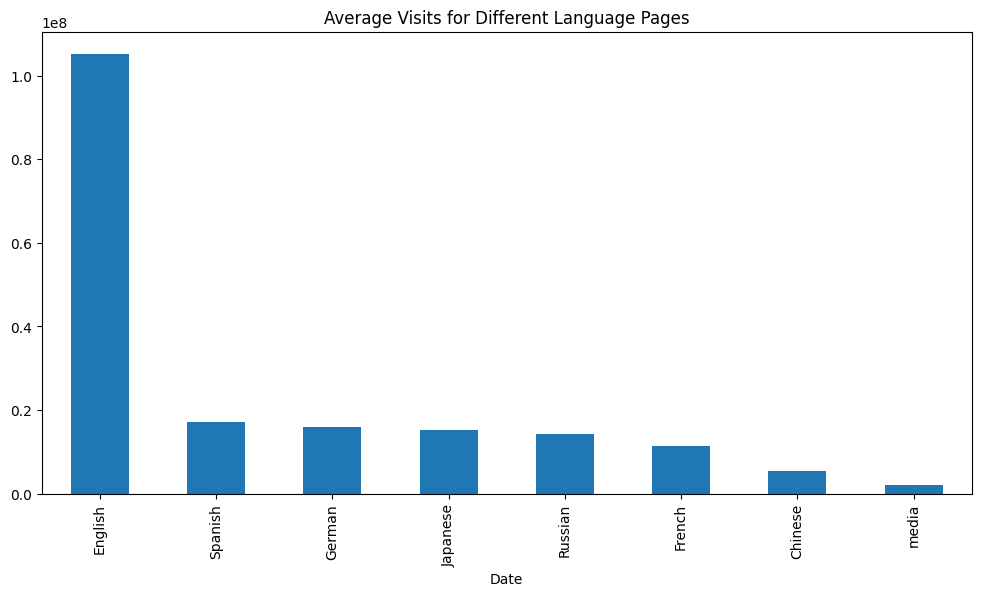

In [149]:
df2.mean().sort_values(ascending=False).plot(kind='bar');
plt.title("Average Visits for Different Language Pages");
plt.show()

## **7. What other methods other than grid search would be suitable to get the model for all languages?**

1. Other than Grid Search, we can also use random search or baysian search.
2. ACF and PACF plots can help in getting the best model as well.
3. Domain understanding can help in getting the best model for all languages
4. Stationary, decompsition and detrend can give understanding while choosing the best model